# 1. Setup (Imports, Config, "Seeds")

In [38]:
# --- Standard library ---
from math import sqrt
from pathlib import Path
import csv
import csv, pathlib
import re
import warnings

# --- Third-party libraries ---
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as _pd
import pandas as pd
import seaborn as sns
import shap


from sklearn.base import clone
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay,
    confusion_matrix, precision_recall_curve
)
import matplotlib.pyplot as plt
from pathlib import Path

# Zusätzliche Modelle
try:
    from xgboost import XGBClassifier
except Exception as e:
    print("[HINWEIS] xgboost nicht installiert? -> pip install xgboost")
    raise

try:
    from lightgbm import LGBMClassifier
except Exception as e:
    print("[HINWEIS] lightgbm nicht installiert? -> pip install lightgbm")
    raise

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
)
from sklearn.inspection import permutation_importance
#Local(falls vorhanden)
#from utils.io import read_csv_robust, load_model, save_model

try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False


In [39]:
# --- Central configuration (paths) ---
from pathlib import Path
import os

# Project root (override via env PROJECT_ROOT if needed)
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", ".")).resolve()

# Base data directories
DATA_DIR = PROJECT_ROOT / 'data'  # adjust if your data lives elsewhere
OUTPUT_DIR = PROJECT_ROOT / 'outputs'  # reports, figures, exports
WORK_DIR = DATA_DIR / 'interim'  # caches / intermediate artifacts
INPUT_DIR = DATA_DIR / 'raw'     # raw input files

for d in (DATA_DIR, OUTPUT_DIR, WORK_DIR, INPUT_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Discovered directories mapped (heuristic from notebook):
ADDITIONAL_FILES_DIR = Path(r'/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files')
CSV_DIR = Path(r'/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv')
CHECKPOINTS_DIR = Path(r'/home/fgimkiew/synthea-parquet-pipeline/notebooks/checkpoints')
MERGED_CSV2_DIR = Path(r'/home/fgimkiew/merged_csv2')
YOUR_DIR = Path(r'/path/to/your')

# File constants (from notebook references)
INTERPRETATIVE_FEATUREBEWERTUNG_ML_WITH_PRIORITY_FLEXIBEL = ADDITIONAL_FILES_DIR / r'Interpretative_Featurebewertung_ML_with_Priority_Flexibel.xlsx'
PATIENTS = CSV_DIR / r'patients.csv'
PATIENTS_FIXED = CSV_DIR / r'patients_fixed.csv'
UNIQUE_CODES_SUMMARY = ADDITIONAL_FILES_DIR / r'unique_codes_summary.csv'
FILTERED_FILE_COVERAGE__0_1 = ADDITIONAL_FILES_DIR / r'filtered_file_Coverage>=0,1.csv'
INTERPRETATIVE_FEATUREBEWERTUNG_ML = ADDITIONAL_FILES_DIR / r'Interpretative_Featurebewertung_ML.xlsx'
PATIENTS_ALL = MERGED_CSV2_DIR / r'patients_all.csv'
OBSERVATIONS = CSV_DIR / r'observations.csv'
_100_000CHECKPOINT_1 = CHECKPOINTS_DIR / r'_100.000checkpoint_1.csv'
TOP_FEATURES_100K = CHECKPOINTS_DIR / r'100.000_top_features.csv'
FILE = YOUR_DIR / r'file.csv'
ALLE_FEATURES_ZEILENWEISE__0_1 = ADDITIONAL_FILES_DIR / r'alle_features_Zeilenweise>=0.1.txt'
FEATURES_AB_PRIORITAET = ADDITIONAL_FILES_DIR / r'Features_ab_Prioritaet.xlsx'


In [40]:
# --- I/O Helpers (robust, drop-in) ---
from pathlib import Path
import os
import pandas as pd

# Optional: saubere, einheitliche Fehlermeldungen
class IOHint(Exception):
    pass

def _ensure_parent_dir(path: Path) -> Path:
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

def _atomic_write(df_writer, path: Path, **kwargs):
    """
    df_writer: lambda tmp_path -> None  (führt den eigentlichen df.to_* Aufruf aus)
    Schreibt erst in .tmp und ersetzt dann atomar.
    """
    p = _ensure_parent_dir(Path(path))
    tmp = p.with_suffix(p.suffix + ".tmp")
    df_writer(tmp, **kwargs)
    tmp.replace(p)

def _infer_compression_from_suffix(path: Path):
    s = Path(path).suffix.lower()
    if s in {".gz", ".gzip"}:
        return "gzip"
    if s == ".bz2":
        return "bz2"
    if s == ".zip":
        return "zip"
    if s == ".xz":
        return "xz"
    return None

# ----------------- READERS -----------------

def read_csv_robust(path,
                    allow_fallbacks: bool = False,
                    fallback_encodings=("utf-8", "utf-8-sig", "latin-1"),
                    **kwargs) -> pd.DataFrame:
    """
    Drop-in Ersatz für pd.read_csv.
    - Erstellt parent dirs NICHT automatisch (Lesen).
    - Optional: Fallback auf andere Encodings / on_bad_lines='skip' (nur wenn allow_fallbacks=True).
    """
    path = Path(path)
    # Kompression aus Dateiendung ableiten, falls nicht gesetzt
    kwargs.setdefault("compression", _infer_compression_from_suffix(path))
    try:
        return pd.read_csv(path, **kwargs)
    except UnicodeDecodeError as e:
        if not allow_fallbacks:
            raise IOHint(f"UnicodeDecodeError bei {path}. Versuche `allow_fallbacks=True` oder setze `encoding=` explizit.") from e
        for enc in fallback_encodings:
            try:
                return pd.read_csv(path, encoding=enc, **kwargs)
            except UnicodeDecodeError:
                continue
        raise
    except pd.errors.ParserError as e:
        if allow_fallbacks and "on_bad_lines" not in kwargs:
            # möglichst schonend: nur wenn explizit erlaubt
            try:
                return pd.read_csv(path, on_bad_lines="skip", **kwargs)
            except Exception:
                pass
        raise

def read_parquet_robust(path,
                        prefer_pyarrow: bool = True,
                        **kwargs) -> pd.DataFrame:
    """
    Drop-in Ersatz für pd.read_parquet.
    - Versucht pyarrow, fällt auf fastparquet zurück, wenn nötig.
    """
    path = Path(path)
    if "engine" not in kwargs and prefer_pyarrow:
        try:
            import pyarrow  # noqa: F401
            return pd.read_parquet(path, engine="pyarrow", **kwargs)
        except Exception:
            pass
    try:
        return pd.read_parquet(path, **kwargs)
    except Exception:
        # letzter Versuch mit fastparquet
        try:
            return pd.read_parquet(path, engine="fastparquet", **kwargs)
        except Exception as e:
            raise IOHint(f"read_parquet fehlgeschlagen für {path}. "
                         f"Installiere ggf. `pyarrow` oder `fastparquet` oder setze `engine=` manuell.") from e

def read_excel_robust(path, **kwargs) -> pd.DataFrame:
    """
    Drop-in Ersatz für pd.read_excel.
    - Lässt alle kwargs durch (sheet_name, header, usecols, dtype, …).
    """
    return pd.read_excel(Path(path), **kwargs)

def read_json_robust(path, **kwargs) -> pd.DataFrame:
    """
    Drop-in Ersatz für pd.read_json.
    """
    return pd.read_json(Path(path), **kwargs)

def read_any(path, **kwargs) -> pd.DataFrame:
    """
    Universal-Leser anhand der Suffixe: .csv, .parquet, .xlsx/.xls, .json
    """
    p = Path(path)
    s = p.suffix.lower()
    if s == ".csv" or s.endswith(".csv.gz") or s.endswith(".csv.bz2"):
        return read_csv_robust(p, **kwargs)
    if s in {".parquet", ".pq"}:
        return read_parquet_robust(p, **kwargs)
    if s in {".xlsx", ".xls"}:
        return read_excel_robust(p, **kwargs)
    if s == ".json":
        return read_json_robust(p, **kwargs)
    raise IOHint(f"Unbekanntes Format für {p}. Unterstützt: csv, parquet, xlsx/xls, json.")

# ----------------- WRITERS -----------------

def to_csv_safe(df, path, **kwargs):
    """
    Drop-in Ersatz für df.to_csv(path, ...), aber:
    - erstellt Ordner automatisch
    - schreibt atomar (.tmp -> rename)
    - übernimmt alle kwargs unverändert (index=, sep=, …)
    """
    comp = kwargs.get("compression")
    if comp is None:
        comp = _infer_compression_from_suffix(path)
        if comp:
            kwargs["compression"] = comp
    _atomic_write(lambda p, **kw: df.to_csv(p, **kw), path, **kwargs)

def to_parquet_safe(df, path, prefer_pyarrow: bool = True, **kwargs):
    """
    Drop-in Ersatz für df.to_parquet(path, ...), aber atomar & parent dirs.
    Engine-Auswahl optional (pyarrow bevorzugt).
    """
    if "engine" not in kwargs and prefer_pyarrow:
        try:
            import pyarrow  # noqa: F401
            kwargs["engine"] = "pyarrow"
        except Exception:
            pass
    _atomic_write(lambda p, **kw: df.to_parquet(p, **kw), path, **kwargs)

def to_excel_safe(df, path, **kwargs):
    _atomic_write(lambda p, **kw: df.to_excel(p, **kw), path, **kwargs)

def to_json_safe(df, path, **kwargs):
    _atomic_write(lambda p, **kw: df.to_json(p, **kw), path, **kwargs)


# Synthea EHR: Patient Feature DataFrame 
Dieses Notebook lädt alle Synthea-CSV-Dateien und führt alle verfügbaren Informationen zu einem Feature-DataFrame zusammen, inklusive Lungenkrebs-Zielvariable. Die ersten beiden code-snippets sind nur nötig um eventuelle kaputte Zeilen aus den heruntergeladenen synthea CSV-Dateien zu löschen und bereinigte CSV Dateien zu erstellen. Danach können die bereinigten CSV Dateien für alle weiteren Schritte verwendet werden und die beiden Snippets somit in Kommentaren "geparkt" werden, bis sie wieder benötigt werden. 


In [41]:
'''
import csv, pathlib

src   = pathlib.Path("/home/fgimkiew/merged_csv2/patients_all.csv")
fixed = src.with_name("patients_all_fixed.csv")
log   = src.with_name("patients_all_badrows.txt")

kept = skipped = 0
with src.open("r", encoding="utf-8", newline="") as fin, \
     fixed.open("w", encoding="utf-8", newline="") as fout, \
     log.open("w", encoding="utf-8") as flog:
    reader = csv.reader(fin, delimiter=",", quotechar='"', doublequote=True)
    writer = csv.writer(fout, delimiter=",", quotechar='"', doublequote=True, lineterminator="\n")
    for i, row in enumerate(reader, 1):
        if i == 1:                     # header
            writer.writerow(row); kept += 1; continue
        if len(row) == 17:
            writer.writerow(row); kept += 1
        else:
            flog.write(f"{i}\t{len(row)}\t{row[:3]} ...\n")
            skipped += 1

print(f"kept={kept}, skipped={skipped}, fixed={fixed}")
'''

'\nimport csv, pathlib\n\nsrc   = pathlib.Path("/home/fgimkiew/merged_csv2/patients_all.csv")\nfixed = src.with_name("patients_all_fixed.csv")\nlog   = src.with_name("patients_all_badrows.txt")\n\nkept = skipped = 0\nwith src.open("r", encoding="utf-8", newline="") as fin,      fixed.open("w", encoding="utf-8", newline="") as fout,      log.open("w", encoding="utf-8") as flog:\n    reader = csv.reader(fin, delimiter=",", quotechar=\'"\', doublequote=True)\n    writer = csv.writer(fout, delimiter=",", quotechar=\'"\', doublequote=True, lineterminator="\n")\n    for i, row in enumerate(reader, 1):\n        if i == 1:                     # header\n            writer.writerow(row); kept += 1; continue\n        if len(row) == 17:\n            writer.writerow(row); kept += 1\n        else:\n            flog.write(f"{i}\t{len(row)}\t{row[:3]} ...\n")\n            skipped += 1\n\nprint(f"kept={kept}, skipped={skipped}, fixed={fixed}")\n'

In [42]:
'''This code snippet performs a **two-stage data quality validation** on a patient CSV file:

## What it does:

1. **Reads the patient data** using robust CSV parsing settings (all columns as strings, no automatic NA inference)

2. **Validates two key fields:**
    - **ID field**: Must be a valid UUID (format: `xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx`)
    - **BIRTHDATE field**: Must be:
      - Valid date in `YYYY-MM-DD` format
      - Within a plausible range (between 1900-01-01 and today)

3. **Splits the data into two files:**
    - **Good records** (`*_uuid_birthdate_ok.csv`): Patients with valid UUID AND valid birthdate
    - **Bad records** (`*_invalid_birthdate_or_uuid.csv`): Patients failing either validation

4. **Reports statistics**: Number of kept vs. removed records

## Key difference from Cell 0:

- **Cell 0** only validates UUID format
- **This cell** validates **both UUID and BIRTHDATE**, providing stricter data quality control

The birthdate validation catches dates that are:
- Malformed (not YYYY-MM-DD)
- Unrealistic (before 1900 or in the future)
- Missing or empty


import re
import pandas as pd
from datetime import datetime

# ---- paths ----
path_in  = "/home/fgimkiew/merged_csv2/patients_all_uuidonly.csv"
path_out = path_in.replace(".csv", "_uuid_birthdate_ok.csv")
path_bad = path_in.replace(".csv", "_invalid_birthdate_or_uuid.csv")

# ---- read (robust) ----
patients = pd.read_csv(
    path_in,
    dtype=str,
    keep_default_na=False,
    na_filter=False,
    sep=",",
    engine="python",      # tolerant
    quotechar='"',
    doublequote=True,
)

# ---- validators ----
UUID_RE = re.compile(r'^[0-9a-f]{8}-(?:[0-9a-f]{4}-){3}[0-9a-f]{12}$', re.IGNORECASE)

def uuid_ok(s: str) -> bool:
    return bool(UUID_RE.match(s or ""))

# Parse YYYY-MM-DD, then constrain to a plausible range (e.g., 1900 .. today)
birth_parsed = pd.to_datetime(
    patients["BIRTHDATE"].str.strip().replace({"": pd.NA}),
    format="%Y-%m-%d",
    errors="coerce"
)

lower = pd.Timestamp("1900-01-01")
upper = pd.Timestamp(datetime.today().date())

birth_ok = birth_parsed.ge(lower) & birth_parsed.le(upper)

uuid_mask = patients["ID"].apply(uuid_ok)

# ---- filter & save ----
good = patients[uuid_mask & birth_ok].copy()
bad  = patients[~(uuid_mask & birth_ok)].copy()

good.to_csv(path_out, index=False)
bad.to_csv(path_bad, index=False)

print(f"✅ kept: {len(good):,}  |  ❌ removed: {len(bad):,}  |  total: {len(patients):,}")
print(f"saved good → {path_out}")
print(f"saved bad  → {path_bad}")
'''

'This code snippet performs a **two-stage data quality validation** on a patient CSV file:\n\n## What it does:\n\n1. **Reads the patient data** using robust CSV parsing settings (all columns as strings, no automatic NA inference)\n\n2. **Validates two key fields:**\n    - **ID field**: Must be a valid UUID (format: `xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx`)\n    - **BIRTHDATE field**: Must be:\n      - Valid date in `YYYY-MM-DD` format\n      - Within a plausible range (between 1900-01-01 and today)\n\n3. **Splits the data into two files:**\n    - **Good records** (`*_uuid_birthdate_ok.csv`): Patients with valid UUID AND valid birthdate\n    - **Bad records** (`*_invalid_birthdate_or_uuid.csv`): Patients failing either validation\n\n4. **Reports statistics**: Number of kept vs. removed records\n\n## Key difference from Cell 0:\n\n- **Cell 0** only validates UUID format\n- **This cell** validates **both UUID and BIRTHDATE**, providing stricter data quality control\n\nThe birthdate validati

 Alle CSV-Dateien laden

In [43]:
def load_csv(file_path: Path):
    name = file_path.stem.replace('_all','')
    # Use the tolerant Python engine for known problematic tables
    if name in ['patients']:
        return read_csv_robust(file_path)
    # All others: fast pyarrow engine
    else:
        return read_csv_robust(file_path)

# Load all CSVs into a dictionary
data = {f.stem.replace('_all',''): load_csv(f) for f in CSV_DIR.glob('*.csv')}

list(data.keys())

['observations',
 'conditions',
 'procedures',
 'patients',
 'careplans',
 'encounters',
 'medications',
 'immunizations',
 'allergies']

 Patienten-ID-Auswahl und Daten filtern

In [44]:
# Alle Patienten verwenden
patients = data['patients'].copy()
patient_ids = set(patients['ID'])

# Hilfsfunktion zum Filtern nach Patient
def filter_patients(df, col='PATIENT'):
    return df[df[col].isin(patient_ids)]

# Alle Tabellen, die eine PATIENT-Spalte haben, filtern
filtered = {k: filter_patients(v) if 'PATIENT' in v.columns else v for k, v in data.items()}

# Demografische Merkmale extrahieren
patients_df = patients[['ID', 'BIRTHDATE', 'GENDER', 'RACE', 'ETHNICITY']].rename(columns={'ID': 'PATIENT'})

patients_df.head(10)
print(len(patients_df))
print(len(patients_df.columns))


132607
5


Zielvariable (Lungenkrebs) aus Diagnosen ableiten

In [45]:
# Deine definierte Liste an SNOMED-Codes für Lungenkrebs
lung_cancer_snomed_codes = [ 
    254637007, 93880001, 253034001, 254638002, 254639005, 254640007,
    187862007, 187863002, 187864008, 254632001, 128632008, 
    254631008, 254630009, 446489004, 408643008, 254633006, 253038003,
    254634000, 93761005, 405939004, 409774003, 236007007
]

# SNOMED-basierte Lungenkrebsdiagnose identifizieren
conditions = filtered['conditions'].copy()
conditions['lung_cancer'] = conditions['CODE'].astype(int).isin(lung_cancer_snomed_codes).astype(int)

# Pro Patient: mindestens eine passende Diagnose = 1
lung_cancer_labels = conditions.groupby('PATIENT')['lung_cancer'].max().reset_index()

# Merge mit den Patientenstammdaten
df = patients_df.merge(lung_cancer_labels, on='PATIENT', how='left')
df['lung_cancer'] = df['lung_cancer'].fillna(0).astype(int)

print(df['lung_cancer'].value_counts())
print(len(df))
print(len(df['PATIENT'].unique()))



lung_cancer
0    128417
1      4190
Name: count, dtype: int64
132607
132607


In [46]:
import pandas as pd

# File path
input_file = CSV_DIR / "observations.csv"

# Load the CSV file
dff = pd.read_csv(input_file)

# Count unique codes in the "CODE" column
unique_codes = dff["CODE"].nunique()

# Print the result
print(f"Total number of unique codes in the 'CODE' column: {unique_codes}")

Total number of unique codes in the 'CODE' column: 63


Labor- und Vitalwerte aus observations.csv

In [47]:
# Lade gefilterte Beobachtungen
obs = filtered['observations'].copy()

# Mapping: CODE → Klartextbeschreibung (z. B. '29463-7' → 'Body Weight')
code_to_name = obs.dropna(subset=['DESCRIPTION']) \
                  .drop_duplicates(subset=['CODE']) \
                  .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: Jeder CODE (z. B. Körpergewicht) wird zu einer Spalte
obs_pivot = obs.pivot_table(
    index='PATIENT',
    columns='CODE',
    values='VALUE',
    aggfunc='first'  # oder 'mean', 'last' je nach Bedarf
).reset_index()

# Spalten umbenennen: CODE → Klartext
obs_pivot.rename(columns=code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(obs_pivot, on='PATIENT', how='left')



Vorschau auf den fertigen DataFrame

In [48]:
df.head()

,PATIENT,BIRTHDATE,GENDER,RACE,ETHNICITY,lung_cancer,Microalbumin Creatine Ratio,Low Density Lipoprotein Cholesterol,FEV1/​FVC,Carbon Dioxide,...,Cat dander IgE Ab in Serum,Honey bee IgE Ab in Serum,Housing status,Total score [MMSE],Cow milk IgE Ab in Serum,Sexual orientation,Body Height,Oral temperature,Diastolic Blood Pressure,Systolic Blood Pressure
0,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,F,white,irish,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,165.05,NaN,87.0,101.0
1,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,1996-09-24,F,white,french_canadian,0,NaN,NaN,NaN,NaN,...,0.12,71.66,NaN,NaN,0.26,NaN,155.77,NaN,70.0,102.0
2,26626faf-cbd5-48d5-a3bf-a7b21ae08e4b,1944-09-01,M,white,irish,0,NaN,96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,176.08,38.0,102.0,186.0
3,f509a0f0-77ef-477f-977d-e2784a241b52,1964-05-14,F,white,french,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4c763cac-b1df-4bcc-b89c-834942c4d3d6,1946-03-05,F,white,irish,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Datenqualität prüfen (fehlende Werte)

In [49]:
# Anteil fehlender Werte pro Spalte
# Compute percentage of missing values per column (i.e., % of patients with no value)
missing_rates = df.isnull().mean().sort_values(ascending=False)

# Convert to DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Share (Patients)': missing_rates
})

# Optional: show top 20 most missing features
missing_summary.head()



,Missing Share (Patients)
Percentage area affected by eczema Trunk,0.995860
Percentage area affected by eczema Upper extremitiy - bilateral,0.995860
Percentage area affected by eczema Head and Neck,0.995860
Percentage area affected by eczema Lower extremitiy - bilateral,0.995860
Total score [MMSE],0.986705


Anzahl verordneter Medikamente pro Patient

In [50]:
# Anzahl verordneter Medikamente
meds = filtered['medications']

# Gruppiere nach Patient: Anzahl verschiedener Medikamentencodes
med_counts = meds.groupby('PATIENT')['CODE'].nunique().reset_index()
med_counts.rename(columns={'CODE': 'num_medications'}, inplace=True)

df = df.merge(med_counts, on='PATIENT', how='left')
df['num_medications'] = df['num_medications'].fillna(0).astype(int)

#Anzahl durchgeführter medizinischer Prozeduren
procedures = filtered['procedures']

proc_counts = procedures.groupby('PATIENT')['CODE'].nunique().reset_index()
proc_counts.rename(columns={'CODE': 'num_procedures'}, inplace=True)

df = df.merge(proc_counts, on='PATIENT', how='left')
df['num_procedures'] = df['num_procedures'].fillna(0).astype(int)

#Anzahl medizinischer Begegnungen (encounters.csv)
encounters = filtered['encounters']
enc_counts = encounters.groupby('PATIENT')['ID'].nunique().reset_index(name='num_encounters')

df = df.merge(enc_counts, on='PATIENT', how='left')
df['num_encounters'] = df['num_encounters'].fillna(0).astype(int)

#Binäres Feature: Hat Allergien?
allergies = filtered['allergies']

# Nur prüfen, ob Allergien vorhanden sind
has_allergy = allergies.groupby('PATIENT').size().reset_index(name='num_allergies')
has_allergy['has_allergy'] = 1  # Nur Existenz zählt

df = df.merge(has_allergy[['PATIENT', 'has_allergy']], on='PATIENT', how='left')
df['has_allergy'] = df['has_allergy'].fillna(0).astype(int)

 Code: Diagnosen als Features (ohne Lungenkrebs)

In [51]:
# Liste der Lungenkrebsdiagnosen, die ausgeschlossen werden sollen
lung_cancer_snomed_codes = [ 
    254637007, 93880001, 253034001, 254638002, 254639005, 254640007,
    187862007, 187863002, 187864008, 254632001, 128632008, 
    254631008, 254630009, 446489004, 408643008, 254633006, 253038003,
    254634000, 93761005, 405939004, 409774003, 236007007
]

# Diagnosen laden
conditions = filtered['conditions'].copy()

# Mapping: CODE → Klartextbeschreibung (optional)
cond_code_to_name = conditions.dropna(subset=['DESCRIPTION']) \
                              .drop_duplicates(subset=['CODE']) \
                              .set_index('CODE')['DESCRIPTION'].to_dict()

# Lungenkrebsdiagnosen ausschließen
conditions = conditions[~conditions['CODE'].astype(int).isin(lung_cancer_snomed_codes)]

# Pivot: Nur Patienten mit Diagnose erhalten 1, andere bleiben NaN
cond_pivot = conditions.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'  # 1, falls vorhanden – sonst NaN
).reset_index()

# Spaltennamen ersetzen durch Beschreibung (wenn vorhanden)
cond_pivot.rename(columns=cond_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(cond_pivot, on='PATIENT', how='left')

#Medikamente -> Sparse Matrix mit NaN
# Lade Medikationstabellen
meds = filtered['medications'].copy()

# Mapping CODE → Klartextbeschreibung (optional)
med_code_to_name = meds.dropna(subset=['DESCRIPTION']) \
                       .drop_duplicates(subset=['CODE']) \
                       .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: Nur Patienten mit Medikation erhalten eine 1 – Rest bleibt NaN
med_pivot = meds.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'
).reset_index()

# Optional: Spaltennamen umbenennen (Code → Beschreibung)
med_pivot.rename(columns=med_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(med_pivot, on='PATIENT', how='left')


# Allergien → Sparse Features mit NaN
# Lade Allergie-Daten
allergies = filtered['allergies'].copy()

# Mapping CODE → Klartextbeschreibung (z. B. Penicillin allergy)
allergy_code_to_name = allergies.dropna(subset=['DESCRIPTION']) \
                                .drop_duplicates(subset=['CODE']) \
                                .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: 1 wenn Allergie vorhanden, NaN wenn nicht vorhanden
allergy_pivot = allergies.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'  # mindestens eine Eintragung = 1
).reset_index()

# Spaltennamen umbenennen (optional: Klartext statt Code)
allergy_pivot.rename(columns=allergy_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(allergy_pivot, on='PATIENT', how='left')


#Impfungen -> Sparse Matrix mit NaN
# Lade Impf-Daten
immunizations = filtered['immunizations'].copy()

# Mapping CODE → Beschreibung (optional: Klartext)
immu_code_to_name = immunizations.dropna(subset=['DESCRIPTION']) \
                                 .drop_duplicates(subset=['CODE']) \
                                 .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: Nur Patienten mit Impfung erhalten eine 1, andere bleiben NaN
immu_pivot = immunizations.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'
).reset_index()

# Klartextnamen statt Codes verwenden (falls vorhanden)
immu_pivot.rename(columns=immu_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(immu_pivot, on='PATIENT', how='left')


#Prozeduren -> Sparse Matrix mit NaN
# Lade Eingriffe / Prozeduren
procedures = filtered['procedures'].copy()

# Mapping CODE → Klartextbeschreibung (optional)
proc_code_to_name = procedures.dropna(subset=['DESCRIPTION']) \
                              .drop_duplicates(subset=['CODE']) \
                              .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: Nur Patienten mit dieser Prozedur erhalten 1, andere bleiben NaN
proc_pivot = procedures.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'
).reset_index()

# Klartextnamen verwenden (wenn vorhanden)
proc_pivot.rename(columns=proc_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(proc_pivot, on='PATIENT', how='left')


#Care Plans -> Sparse Matrix mit NaN
# Lade Careplans
careplans = filtered['careplans'].copy()

# Mapping CODE → Klartextbeschreibung (optional)
cp_code_to_name = careplans.dropna(subset=['DESCRIPTION']) \
                           .drop_duplicates(subset=['CODE']) \
                           .set_index('CODE')['DESCRIPTION'].to_dict()

# Pivot: Nur Patienten mit Care Plan erhalten 1, andere bleiben NaN
cp_pivot = careplans.assign(value=1).pivot_table(
    index='PATIENT',
    columns='CODE',
    values='value',
    aggfunc='max'
).reset_index()

# Spalten umbenennen mit Beschreibung (falls vorhanden)
cp_pivot.rename(columns=cp_code_to_name, inplace=True)

# Merge mit Haupt-DataFrame
df = df.merge(cp_pivot, on='PATIENT', how='left')

#dataframe prüfen
df.head()

,PATIENT,BIRTHDATE,GENDER,RACE,ETHNICITY,lung_cancer,Microalbumin Creatine Ratio,Low Density Lipoprotein Cholesterol,FEV1/​FVC,Carbon Dioxide,...,Skin condition care,Delivery of rehabilitation for spinal cord injury,Self care,Allergen immunotherapy drugs Band 1,Major surgery care management,Depression care management,Surgery care management,Education about dementia,Urinary tract infection care,Musculoskeletal care
0,660bec03-9e58-47f2-98b9-2f1c564f3838,1996-07-26,F,white,irish,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,5125d2b2-3aef-4ae2-aa5c-335f7e206b92,1996-09-24,F,white,french_canadian,0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,26626faf-cbd5-48d5-a3bf-a7b21ae08e4b,1944-09-01,M,white,irish,0,NaN,96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f509a0f0-77ef-477f-977d-e2784a241b52,1964-05-14,F,white,french,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4c763cac-b1df-4bcc-b89c-834942c4d3d6,1946-03-05,F,white,irish,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Datenqualität Prüfen (fehlende Werte)

In [52]:
# Anteil fehlender Werte pro Spalte
# Compute percentage of missing values per column (i.e., % of patients with no value)
missing_rates = df.isnull().mean().sort_values(ascending=True)

# Convert to DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Share (Patients)': missing_rates
})

# Optional: show top 20 most missing features
missing_summary.head(61)

,Missing Share (Patients)
PATIENT,0.000000
BIRTHDATE,0.000000
GENDER,0.000000
RACE,0.000000
ETHNICITY,0.000000
...,...
Measurement of respiratory function (procedure),0.875519
meningococcal MCV4P,0.879524
Amoxicillin 250 MG / Clavulanate 125 MG [Augmentin],0.883656
Angina self management plan,0.883867


Speichere das finale DataFrame als CSV-Datei

In [53]:
# Speicherpfad (anpassen nach Wunsch)
#output_path = "/home/fgimkiew/synthea-parquet-pipeline/notebooks/checkpoints/_100.000checkpoint_1.csv"
output_path = CHECKPOINTS_DIR / r'_100.000checkpoint_1.csv'

# DataFrame speichern
df.to_csv(output_path, index=False)

print(f"Datei gespeichert unter: {output_path}")

num_columns = len(df.columns)
print(f"Anzahl der Spalten: {num_columns}")
num_rows = len(df)
print(f"Anzahl der Zeilen: {num_rows}")
print(len(df.columns[df.isnull().mean() < 0.9].tolist()))

Datei gespeichert unter: /home/fgimkiew/synthea-parquet-pipeline/notebooks/checkpoints/_100.000checkpoint_1.csv
Anzahl der Spalten: 469
Anzahl der Zeilen: 132607
60


Coverage der häufigsten 100 Features Plotten


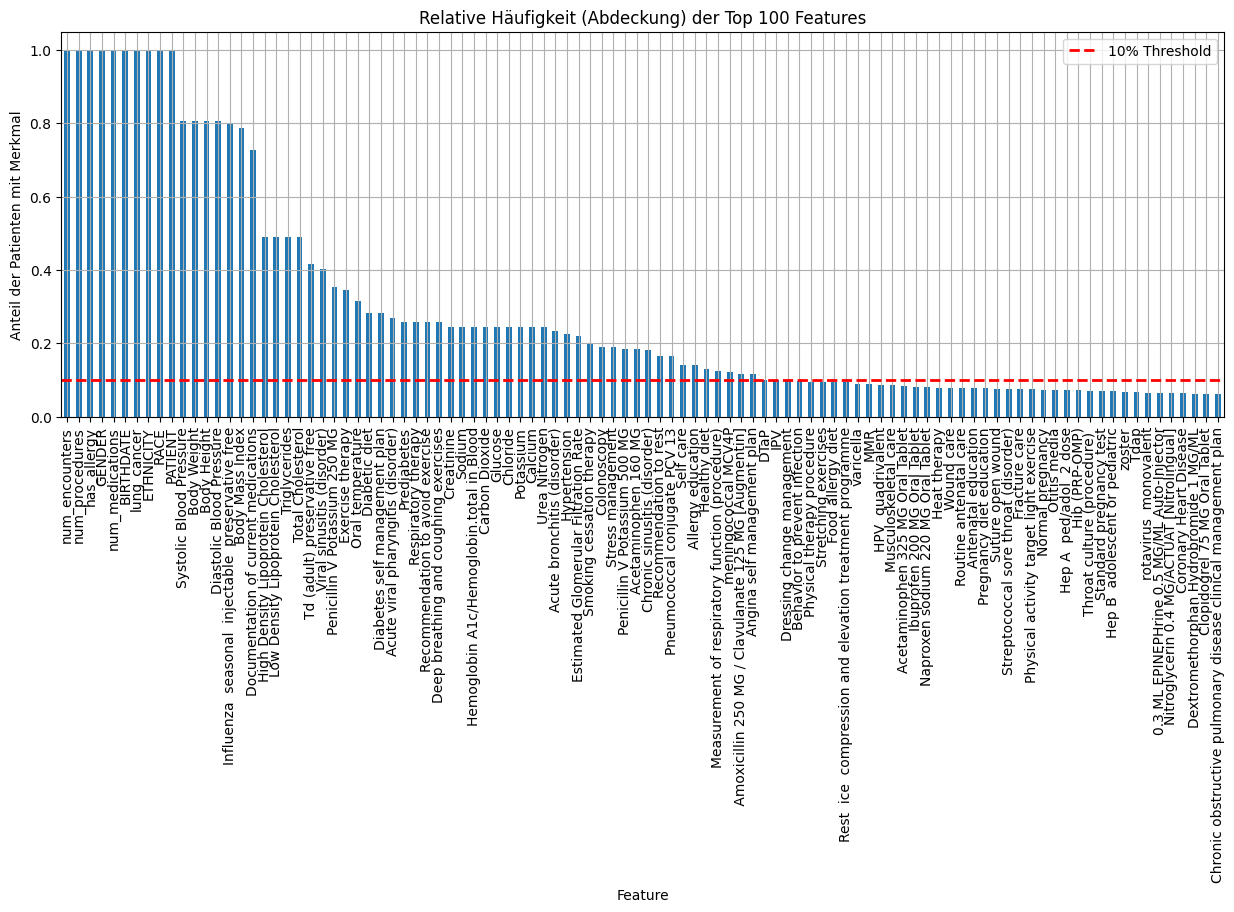

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# df ist dein ML-DataFrame mit Patientendaten (binary: 1 = Merkmal vorhanden, NaN = nicht vorhanden)
# Zähle, wie viele Patienten pro Feature einen Wert haben (also kein NaN)
feature_counts = df.notna().sum()

# Sortiere absteigend
feature_counts = feature_counts.sort_values(ascending=False)

# Optional: relative Häufigkeit (z. B. für %-Angabe)
relative_freq = feature_counts / len(df)

# Plot der relativen Häufigkeit der Top 100 Features
plt.figure(figsize=(15, 5))
relative_freq.head(100).plot(kind='bar')
plt.title('Relative Häufigkeit (Abdeckung) der Top 100 Features')
plt.ylabel('Anteil der Patienten mit Merkmal')
plt.xlabel('Feature')
plt.grid(True)
plt.tight_layout()
# Draw a horizontal line at 10% threshold
plt.axhline(y=0.1, color='r', linestyle='--', linewidth=2, label='10% Threshold')
plt.legend()
plt.show()


Notitz: bei 100.000 Datensatz: Knick in der Coverage jeweils bei ca. 30% und 20% erkennbar, bei 10% eher gradueller Verlauf

In [55]:


# Load your original DataFrame
#input_file = "/path/to/your/file.csv"
#df = pd.read_csv(input_file)

# Calculate coverage for each column
coverage_threshold = 0.10  # Minimum coverage (10%)
column_coverage = df.notnull().mean()  # Fraction of non-null values per column

# Filter columns with coverage >= 10%
columns_to_keep = column_coverage[column_coverage >= coverage_threshold].index
filtered_df = df[columns_to_keep]

# Save the filtered DataFrame to a new file (optional)
#output_file = ADDITIONAL_FILES_DIR / "filtered_file_Coverage>=0.1.csv"
output_file = FILTERED_FILE_COVERAGE__0_1
filtered_df.to_csv(output_file, index=False)

# Print the columns retained
print(f"Original number of columns: {len(df.columns)}")
print(f"Number of columns after filtering: {len(columns_to_keep)}")
print(f"Filtered DataFrame saved to: {output_file}")
print(f"Columns retained with at least 10% coverage: {list(columns_to_keep)}")

Original number of columns: 469
Number of columns after filtering: 60
Filtered DataFrame saved to: /home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/filtered_file_Coverage>=0,1.csv
Columns retained with at least 10% coverage: ['PATIENT', 'BIRTHDATE', 'GENDER', 'RACE', 'ETHNICITY', 'lung_cancer', 'Low Density Lipoprotein Cholesterol', 'Carbon Dioxide', 'Chloride', 'High Density Lipoprotein Cholesterol', 'Total Cholesterol', 'Glucose', 'Triglycerides', 'Body Weight', 'Sodium', 'Estimated Glomerular Filtration Rate', 'Creatinine', 'Body Mass Index', 'Hemoglobin A1c/Hemoglobin.total in Blood', 'Calcium', 'Potassium', 'Urea Nitrogen', 'Body Height', 'Oral temperature', 'Diastolic Blood Pressure', 'Systolic Blood Pressure', 'num_medications', 'num_procedures', 'num_encounters', 'has_allergy', 'Acute bronchitis (disorder)', 'Prediabetes', 'Hypertension', 'Chronic sinusitis (disorder)', 'Acute viral pharyngitis (disorder)', 'Viral sinusitis (disorder)', 'Acetaminophen 16

In [56]:




# Beispiel: DataFrame laden
# df = pd.read_csv("deine_datei.csv")

# Name der Ausgabedatei
#output_path = ADDITIONAL_FILES_DIR / 'alle_features_Zeilenweise>=0.1.txt'
output_path = ALLE_FEATURES_ZEILENWEISE__0_1

# Coverage für jede Spalte berechnen
coverage = df.notna().mean() * 100  # Anteil der Nicht-NaN-Werte in Prozent

# Nur Spalten mit >= 10% Coverage behalten
filtered = coverage[coverage >= 10]

# Nach Coverage absteigend sortieren (optional, aber übersichtlicher)
filtered = filtered.sort_values(ascending=False)

# Datei schreiben
with open(output_path, "w", encoding="utf-8") as f:
    for col, cov in filtered.items():
        f.write(f"{col}, {cov:.2f}%\n")

print(f"✅ Datei '{output_path}' erstellt mit {len(filtered)} Features (≥10% Coverage).")




✅ Datei '/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/alle_features_Zeilenweise>=0.1.txt' erstellt mit 60 Features (≥10% Coverage).


In [57]:
#1

# 1) Laden
#input_path = ADDITIONAL_FILES_DIR / 'Interpretative_Featurebewertung_ML.xlsx'
input_path = INTERPRETATIVE_FEATUREBEWERTUNG_ML
df = pd.read_excel(input_path)
df.columns = df.columns.str.strip()

# 2) Relevanz -> numerisch
def map_relevance(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    if "sehr hoch" in s:            return 3.5
    elif "mittel bis hoch" in s:    return 2.5
    elif "niedrig bis mittel" in s: return 1.5
    elif "hoch" in s:               return 3.0
    elif "mittel" in s:             return 2.0
    elif "niedrig" in s:            return 1.0
    elif "keine" in s:              return 0.0
    else:                           return np.nan

df["Relevanz_Score"] = df["Relevanzeinschätzung"].apply(map_relevance).astype(float)

# 3) Abdeckungsrate "%" -> float in [0,1]
cov_str = df["Abdeckungsrate"].astype(str).str.strip()
cov_str = cov_str.str.replace("%", "", regex=False).str.replace(",", ".", regex=False)
df["Abdeckungsrate_num"] = pd.to_numeric(cov_str, errors="coerce") / 100.0

# 4) Priorität = Relevanz * Coverage
df["Priorität"] = df["Relevanz_Score"] * df["Abdeckungsrate_num"]

# Optional: Skala 0–100
# df["Priorität(0-100)"] = df["Priorität"] * 100

# 5) sortieren + speichern
df_sorted = df.sort_values("Priorität", ascending=False)
#output_path = "/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/Interpretative_Featurebewertung_ML_with_Priority_Flexibel.xlsx"
output_path = INTERPRETATIVE_FEATUREBEWERTUNG_ML_WITH_PRIORITY_FLEXIBEL
df_sorted.to_excel(output_path, index=False)
print(f"Datei gespeichert unter: {output_path}")


Datei gespeichert unter: /home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/Interpretative_Featurebewertung_ML_with_Priority_Flexibel.xlsx


Alles klar 👍
Hier ist der gesonderte Code, der aus deiner fertigen Prioritätsmatrix die Top-N Features fürs ML-Modell extrahiert – ohne die Zielvariable lung_cancer:

In [58]:


# 1. Prioritätsmatrix laden (bereits mit "Priorität"-Spalte)
#input_path = ADDITIONAL_FILES_DIR / 'Interpretative_Featurebewertung_ML_with_Priority_Flexibel.xlsx'
input_path = INTERPRETATIVE_FEATUREBEWERTUNG_ML_WITH_PRIORITY_FLEXIBEL
df = pd.read_excel(input_path)

# 2. Zielvariable entfernen
df = df[df["Feature"] != "lung_cancer"]

# 3. Nach Priorität sortieren (falls nicht schon sortiert)
df = df.sort_values(by="Priorität", ascending=False)

# 4. Top-N Features auswählen
N = 20  # Anzahl der gewünschten Features
top_features = df.head(N)

# 5. Ergebnis anzeigen
print("Top Features (ohne Zielvariable):")
print(top_features[["Feature", "Priorität", "Relevanz_Score", "Abdeckungsrate"]])

# 6. Optional: In eine neue Datei exportieren
output_path = ADDITIONAL_FILES_DIR / f"Top_{N}_Features_no_target.xlsx"

top_features.to_excel(output_path, index=False)
print(f"Datei gespeichert unter: {output_path}")


Top Features (ohne Zielvariable):
                                              Feature  Priorität  \
1                                             PATIENT     3.0000   
2                                              GENDER     3.0000   
3                                           BIRTHDATE     3.0000   
4                                                RACE     3.0000   
5                                           ETHNICITY     3.0000   
6                                         Body Height     2.4195   
7                                         Body Weight     2.4195   
8                             Systolic Blood Pressure     2.4195   
9                            Diastolic Blood Pressure     2.4195   
10                                     num_procedures     2.0000   
11  Influenza  seasonal  injectable  preservative ...     1.6038   
12                                  Total Cholesterol     1.4712   
13               High Density Lipoprotein Cholesterol     1.4712   
14            

In [59]:


# === Parameter ==========================================
#INPUT_PATH = ADDITIONAL_FILES_DIR / 'Interpretative_Featurebewertung_ML_with_Priority_Flexibel.xlsx'
INPUT_PATH = INTERPRETATIVE_FEATUREBEWERTUNG_ML_WITH_PRIORITY_FLEXIBEL
#OUTPUT_PATH = ADDITIONAL_FILES_DIR / 'Features_ab_Prioritaet.xlsx'
OUTPUT_PATH = FEATURES_AB_PRIORITAET
PRIOR_THRESHOLD = 0.5   # <-- Schwelle für die Spalte "Priorität"
EXCLUDE_TARGET = "lung_cancer"
# ========================================================

# 1) Datei laden
df = pd.read_excel(INPUT_PATH)
df.columns = df.columns.str.strip()

# 2) Zielvariable ausschließen
df = df[df["Feature"] != EXCLUDE_TARGET]

# 3) Sicherstellen, dass "Priorität" vorhanden und numerisch ist
if "Priorität" not in df.columns:
    raise ValueError("Spalte 'Priorität' fehlt. Bitte zuerst die Prioritätsmatrix erstellen.")
df["Priorität"] = pd.to_numeric(df["Priorität"], errors="coerce")

# 4) Nach Schwelle filtern und sortieren
mask = df["Priorität"] >= PRIOR_THRESHOLD
df_sel = df[mask].sort_values(by="Priorität", ascending=False)

# 5) Ergebnis speichern & kurz berichten
df_sel.to_excel(OUTPUT_PATH, index=False)

print(f"Gesamt-Features (ohne Zielvariable): {len(df)}")
print(f"Ausgewählt ab Priorität ≥ {PRIOR_THRESHOLD}: {len(df_sel)}")
print(f"Gespeichert unter: {Path(OUTPUT_PATH).resolve()}")
print("\nVorschau:")
print(df_sel[["Feature", "Priorität", "Relevanz_Score", "Abdeckungsrate"]].head(20))


Gesamt-Features (ohne Zielvariable): 59
Ausgewählt ab Priorität ≥ 0.5: 44
Gespeichert unter: /home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/Features_ab_Prioritaet.xlsx

Vorschau:
                                              Feature  Priorität  \
1                                             PATIENT     3.0000   
2                                              GENDER     3.0000   
3                                           BIRTHDATE     3.0000   
4                                                RACE     3.0000   
5                                           ETHNICITY     3.0000   
6                                         Body Height     2.4195   
7                                         Body Weight     2.4195   
8                             Systolic Blood Pressure     2.4195   
9                            Diastolic Blood Pressure     2.4195   
10                                     num_procedures     2.0000   
11  Influenza  seasonal  injectable  preservati

In [60]:
#5
# =========================
# 0) SETUP & PARAMETER
# =========================
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

TARGET = "lung_cancer"

# Feature-Auswahl: nach Prioritätsschwelle ODER top-N (eine Variante aktiv lassen)
PRIORITY_THRESHOLD = 0.5     # <- alle Features mit Priorität >= 0.5
TOP_N = None                 # <- alternativ: feste Anzahl (z.B. 40). Wenn None, wird Schwelle genutzt.

# Korrelation/Redundanz
SPEARMAN_THRESHOLD = 0.85    # |rho| >= 0.85 => stark korreliert (numerisch)
CRAMERS_THRESHOLD  = 0.85    # V >= 0.85 => stark assoziiert (binär/kateg.)

# Cross-Validation
N_SPLITS = 5
RANDOM_STATE = 42

# Ausgabeordner
OUTDIR = Path("analysis_outputs_100.000")
OUTDIR.mkdir(exist_ok=True)
print("Output-Folder:", OUTDIR.resolve())


Output-Folder: /home/fgimkiew/synthea-parquet-pipeline/notebooks/analysis_outputs_100.000


In [61]:

plt.rcParams["figure.figsize"] = (7, 5)  # keine Farben explizit setzen, 1 Plot pro Figure



In [62]:
#6
# =========================
# 2) DATEN LADEN
# =========================
df = read_csv_robust(FILTERED_FILE_COVERAGE__0_1)
print(df.shape, " | Spalten-Beispiel:", list(df.columns[:10]))

# Zielvariable prüfen
assert TARGET in df.columns, f"Zielvariable '{TARGET}' nicht in CSV gefunden."

# Metadaten (Priorität) laden
meta = pd.read_excel(INTERPRETATIVE_FEATUREBEWERTUNG_ML_WITH_PRIORITY_FLEXIBEL)
meta.columns = meta.columns.str.strip()

# Nur die 152 gefilterten Features + ihre Priorität
meta = meta[["Feature", "Abdeckungsrate", "Relevanz_Score", "Priorität"]].dropna(subset=["Feature"])

# Zielvariable nicht als Kandidat
meta = meta[meta["Feature"] != TARGET]

# Verfügbare Kandidaten = Schnittmenge (Meta ∩ CSV)
candidates = [f for f in meta["Feature"].tolist() if f in df.columns]
meta = meta[meta["Feature"].isin(candidates)].copy()
len(candidates), candidates[:10]


(132607, 60)  | Spalten-Beispiel: ['PATIENT', 'BIRTHDATE', 'GENDER', 'RACE', 'ETHNICITY', 'lung_cancer', 'Low Density Lipoprotein Cholesterol', 'Carbon Dioxide', 'Chloride', 'High Density Lipoprotein Cholesterol']


(58,
 ['PATIENT',
  'GENDER',
  'BIRTHDATE',
  'RACE',
  'ETHNICITY',
  'Body Height',
  'Body Weight',
  'Systolic Blood Pressure',
  'Diastolic Blood Pressure',
  'num_procedures'])

In [63]:
#7
# =========================
# 3) FEATURE-SELEKTION (Priority)
# =========================
if TOP_N is not None:
    meta_sorted = meta.sort_values("Priorität", ascending=False)
    selected_feats = meta_sorted.head(int(TOP_N))["Feature"].tolist()
else:
    selected_feats = meta.loc[meta["Priorität"] >= PRIORITY_THRESHOLD, "Feature"].tolist()

print(f"Ausgewählte Features (ohne '{TARGET}'): {len(selected_feats)}")
selected_feats[:25]


Ausgewählte Features (ohne 'lung_cancer'): 44


['PATIENT',
 'GENDER',
 'BIRTHDATE',
 'RACE',
 'ETHNICITY',
 'Body Height',
 'Body Weight',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'num_procedures',
 'Influenza  seasonal  injectable  preservative free',
 'Total Cholesterol',
 'High Density Lipoprotein Cholesterol',
 'Triglycerides',
 'Low Density Lipoprotein Cholesterol',
 'Viral sinusitis (disorder)',
 'Penicillin V Potassium 250 MG',
 'num_medications',
 'num_encounters',
 'has_allergy',
 'Diabetic diet',
 'Oral temperature',
 'Recommendation to avoid exercise',
 'Deep breathing and coughing exercises',
 'Diabetes self management plan']

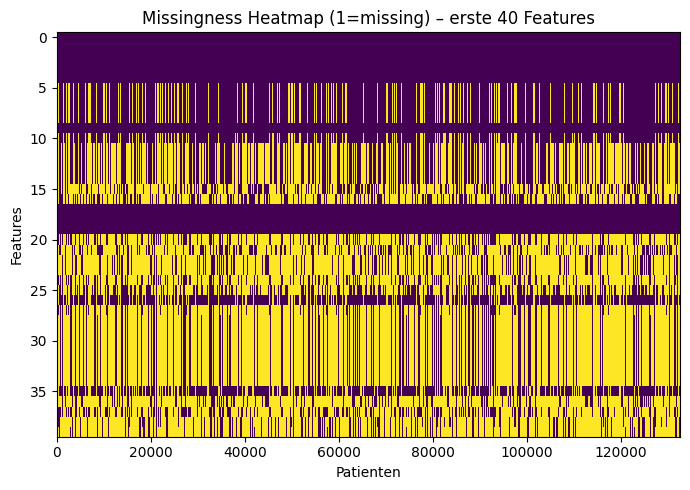

In [64]:
#8
# =========================
# 4) COVERAGE & MISSINGNESS
# =========================
def compute_coverage(df_sub: pd.DataFrame):
    counts = df_sub.notna().sum()
    cov = counts / len(df_sub)
    return pd.DataFrame({"Feature": df_sub.columns, "Count": counts.values, "Coverage": cov.values})

X = df[selected_feats].copy()
y = df[TARGET].copy()

coverage_df = compute_coverage(X)
coverage_df.to_csv(OUTDIR / "coverage_selected.csv", index=False)

# Einfache "Missingness-Heatmap" (für die ersten 40 Features, damit es lesbar bleibt)
Xmiss = X.iloc[:, :min(40, X.shape[1])].isna().astype(int)
plt.figure()
plt.imshow(Xmiss.T, aspect="auto", interpolation="nearest")
plt.title("Missingness Heatmap (1=missing) – erste 40 Features")
plt.xlabel("Patienten")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [65]:
# --- Robust: sel_nonredundant sicherstellen -------------------------------
# Voraussetzungen:
# - df: dein DataFrame mit allen Spalten
# - TARGET: Name deiner Zielvariable (z. B. "lung_cancer")

# Falls TARGET noch nicht gesetzt ist, HIER einmalig definieren:
# TARGET = "lung_cancer"   # <- ggf. anpassen

# Optionale Spalten, die du grundsätzlich NICHT als Feature verwenden willst
ALWAYS_EXCLUDE = {
    TARGET, 
    "PATIENT", "BIRTHDATE", "patient_id", "encounter_id"  # nach Bedarf anpassen/erweitern
}

def is_defined(name: str) -> bool:
    return name in globals() or name in locals()

# Falls du bereits früher eine Feature-Liste erzeugt hast (z. B. sel_features),
# kannst du sie hier bevorzugen. Sonst nehmen wir alle df-Spalten außer den Excludes.
if not is_defined("sel_nonredundant"):
    # 1) Basis: alle Spalten außer den Excludes
    base_feats = [c for c in df.columns if c not in ALWAYS_EXCLUDE]
    
    # 2) Optional: Wenn du eine kuratierte Liste (z. B. die 152 Features) hast, schneide auf den Schnitt
    # Beispiel: falls du sie als Liste 'FEATURES_152' in der Session hast:
    if is_defined("FEATURES_152"):
        sel_nonredundant = [c for c in base_feats if c in set(FEATURES_152)]
    else:
        sel_nonredundant = base_feats

# Sanity-Checks & Diagnose
missing = [c for c in sel_nonredundant if c not in df.columns]
if missing:
    print("[WARN] Diese Spalten aus sel_nonredundant fehlen im df und werden ignoriert:", missing)
    sel_nonredundant = [c for c in sel_nonredundant if c in df.columns]

print(f"[Diag] Anzahl ausgewählter Features (sel_nonredundant): {len(sel_nonredundant)}")
print("Beispiele:", sel_nonredundant[:10])


[Diag] Anzahl ausgewählter Features (sel_nonredundant): 44
Beispiele: ['PATIENT', 'GENDER', 'BIRTHDATE', 'RACE', 'ETHNICITY', 'Body Height', 'Body Weight', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'num_procedures']


### Erklärung: Robuste Definition von `sel_nonredundant`

Dieses Snippet sorgt dafür, dass die Feature-Liste `sel_nonredundant` immer gültig und konsistent ist.

- **Ausschlussliste:** Bestimmte Spalten werden niemals als Features verwendet  
  (z. B. `lung_cancer`, Patient-ID, Geburtsdatum).

- **Prüfung:** Wenn `sel_nonredundant` noch nicht existiert, wird es neu erstellt.  
  Falls es schon früher definiert wurde, bleibt es bestehen.

- **Basis-Features:** Alle Spalten des DataFrames, außer die ausgeschlossenen.

- **Optionale Einschränkung:** Wenn es eine kuratierte Feature-Liste (`FEATURES_152`) gibt,  
  wird der Schnitt beider Listen genommen (nur gemeinsame Features bleiben).

- **Sicherheits-Check:** Nicht vorhandene Spalten werden entfernt,  
  und es gibt eine Warnung, welche Spalten fehlen.

- **Ausgabe:**  
  - Anzahl der final ausgewählten Features  
  - Beispiel der ersten 10 Feature-Namen


In [66]:
#9
# =========================
# 5) ROBUSTE TYP-HEURISTIK (binär / numerisch / kategorisch)
# =========================


def is_binary_series(s: pd.Series):
    """Echte Binärspalte (0/1/True/False) mit evtl. NaNs."""
    vals = pd.unique(s.dropna())
    return set(vals).issubset({0, 1, True, False})

def infer_types(df_in: pd.DataFrame, numeric_ratio_threshold: float = 0.98):
    """
    Weist jede Spalte robust einem Typ zu:
      - binär (0/1/bool)
      - numerisch (>= numeric_ratio_threshold der Nicht-NaNs sind numerisch parsible)
      - kategorisch (Rest: Strings / gemischt)
    """
    bin_cols, num_cols, cat_cols = [], [], []
    for c in df_in.columns:
        s = df_in[c]
        if is_binary_series(s):
            bin_cols.append(c)
            continue

        # versuche numerisch zu parsen
        s_coerced = pd.to_numeric(s, errors="coerce")
        numeric_share = s_coerced.notna().mean()  # Anteil der Werte, die als Zahl lesbar sind

        if numeric_share >= numeric_ratio_threshold:
            num_cols.append(c)
        else:
            cat_cols.append(c)

    return bin_cols, num_cols, cat_cols

# Auf deine aktuelle Feature-Menge anwenden:
X = df[sel_nonredundant].copy()
y = df[TARGET].copy()

bin_feats, num_feats, cat_feats = infer_types(X)

print(f"Binär: {len(bin_feats)} | Numerisch: {len(num_feats)} | Kategorisch: {len(cat_feats)}")
# Optional: zur Diagnose
#print("Beispiele cat:", cat_feats[:10])



Binär: 19 | Numerisch: 3 | Kategorisch: 22


In [67]:
'''
#10
# =========================
# 6) REDUNDANZ: SPEARMAN (numerisch) & CRAMÉR's V (binär)
# =========================
from scipy.stats import spearmanr
from math import sqrt

def cramers_v(x, y):
    # Cramér's V für binäre/kategoriale Spalten
    tab = pd.crosstab(x, y)
    chi2 = ((tab - tab.mean(axis=0))**2 / tab.mean(axis=0)).sum().sum()  # schnelle Näherung
    n = tab.sum().sum()
    r, k = tab.shape
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    v = sqrt(phi2 / min(k - 1, r - 1)) if min(k-1, r-1) > 0 else np.nan
    return v

# Spearman für numerische
spearman_pairs = []
if len(num_feats) > 1:
    for i in range(len(num_feats)):
        for j in range(i+1, len(num_feats)):
            a, b = num_feats[i], num_feats[j]
            s = X[[a, b]].dropna()
            if len(s) > 5:
                rho, _ = spearmanr(s[a], s[b])
                spearman_pairs.append((a, b, abs(rho)))

spearman_df = pd.DataFrame(spearman_pairs, columns=["feat1", "feat2", "abs_spearman"]).sort_values("abs_spearman", ascending=False)
spearman_df.to_csv(OUTDIR / "redundancy_spearman_pairs.csv", index=False)

# Cramér's V für binäre (ACHTUNG: O(n^2) – ggf. deckeln)
cramers_pairs = []
BIN_LIMIT = min(len(bin_feats), 120)  # zur Laufzeitbegrenzung
bin_subset = bin_feats[:BIN_LIMIT]

for i in range(len(bin_subset)):
    for j in range(i+1, len(bin_subset)):
        a, b = bin_subset[i], bin_subset[j]
        v = cramers_v(X[a], X[b])
        cramers_pairs.append((a, b, v))

cramers_df = pd.DataFrame(cramers_pairs, columns=["feat1", "feat2", "cramers_v"]).sort_values("cramers_v", ascending=False)
cramers_df.to_csv(OUTDIR / "redundancy_cramers_pairs.csv", index=False)

# Einfache Regel: in stark korrelierten Paaren den mit geringerer Priorität rauswerfen
priority_map = meta.set_index("Feature")["Priorität"].to_dict()

to_drop = set()

# numerisch
for _, row in spearman_df[spearman_df["abs_spearman"] >= SPEARMAN_THRESHOLD].iterrows():
    a, b = row["feat1"], row["feat2"]
    pa, pb = priority_map.get(a, 0), priority_map.get(b, 0)
    drop = a if pa < pb else b
    to_drop.add(drop)

# binär
for _, row in cramers_df[cramers_df["cramers_v"] >= CRAMERS_THRESHOLD].iterrows():
    a, b = row["feat1"], row["feat2"]
    pa, pb = priority_map.get(a, 0), priority_map.get(b, 0)
    drop = a if pa < pb else b
    to_drop.add(drop)

print(f"Redundante Kandidaten (werden entfernt): {len(to_drop)}")
sel_nonredundant = [f for f in selected_feats if f not in to_drop]
len(sel_nonredundant)
'''

'\n#10\n# =========================\n# 6) REDUNDANZ: SPEARMAN (numerisch) & CRAMÉR\'s V (binär)\n# =========================\nfrom scipy.stats import spearmanr\nfrom math import sqrt\n\ndef cramers_v(x, y):\n    # Cramér\'s V für binäre/kategoriale Spalten\n    tab = pd.crosstab(x, y)\n    chi2 = ((tab - tab.mean(axis=0))**2 / tab.mean(axis=0)).sum().sum()  # schnelle Näherung\n    n = tab.sum().sum()\n    r, k = tab.shape\n    if n == 0:\n        return np.nan\n    phi2 = chi2 / n\n    v = sqrt(phi2 / min(k - 1, r - 1)) if min(k-1, r-1) > 0 else np.nan\n    return v\n\n# Spearman für numerische\nspearman_pairs = []\nif len(num_feats) > 1:\n    for i in range(len(num_feats)):\n        for j in range(i+1, len(num_feats)):\n            a, b = num_feats[i], num_feats[j]\n            s = X[[a, b]].dropna()\n            if len(s) > 5:\n                rho, _ = spearmanr(s[a], s[b])\n                spearman_pairs.append((a, b, abs(rho)))\n\nspearman_df = pd.DataFrame(spearman_pairs, columns

In [68]:
#10
# =========================
# 6) REDUNDANZ: SPEARMAN (numerisch) & CRAMÉR's V (binär)
# =========================
from scipy.stats import spearmanr, chi2_contingency
import numpy as np
import pandas as pd

def cramers_v(x, y):
    """
    Cramér's V für kategoriale/binaire Variablen auf Basis einer Kontingenztafel
    (robust mit chi2_contingency).
    Erwartet KEINE NaNs (für binäre Features vorher fillna(0) machen).
    """
    tab = pd.crosstab(x, y)
    n = tab.to_numpy().sum()

    # Keine Daten oder keine echte 2x2 (oder generell <2 Kategorien)
    if n == 0 or tab.shape[0] < 2 or tab.shape[1] < 2:
        return np.nan

    chi2, _, _, _ = chi2_contingency(tab, correction=False)
    r, k = tab.shape
    return np.sqrt((chi2 / n) / min(k - 1, r - 1))


# -------------------------
# Spearman für numerische
# -------------------------
spearman_pairs = []
if len(num_feats) > 1:
    for i in range(len(num_feats)):
        for j in range(i + 1, len(num_feats)):
            a, b = num_feats[i], num_feats[j]
            s = X[[a, b]].dropna()
            if len(s) > 5:
                rho, _ = spearmanr(s[a], s[b])
                spearman_pairs.append((a, b, abs(rho)))

spearman_df = (
    pd.DataFrame(spearman_pairs, columns=["feat1", "feat2", "abs_spearman"])
      .sort_values("abs_spearman", ascending=False)
)
spearman_df.to_csv(OUTDIR / "redundancy_spearman_pairs.csv", index=False)


# -------------------------
# Cramér's V für binäre
# -------------------------
cramers_pairs = []
BIN_LIMIT = min(len(bin_feats), 120)  # zur Laufzeitbegrenzung
bin_subset = bin_feats[:BIN_LIMIT]

# WICHTIG: NaNs -> 0, damit crosstab nicht "leer" wird
# (bei dir: 1 = vorhanden, NaN = nicht vorhanden)
X_bin = X[bin_subset].fillna(0).astype(int)

# Optionaler Quick-Check: Wie "sparse" ist das?
print("Binary subset size:", len(bin_subset))
print("Mean prevalence (avg of columns):", float(X_bin.mean().mean()))
print("Columns with zero variance:", int((X_bin.nunique() < 2).sum()))

for i in range(len(bin_subset)):
    for j in range(i + 1, len(bin_subset)):
        a, b = bin_subset[i], bin_subset[j]
        v = cramers_v(X_bin[a], X_bin[b])
        cramers_pairs.append((a, b, v))

cramers_df = (
    pd.DataFrame(cramers_pairs, columns=["feat1", "feat2", "cramers_v"])
      .sort_values("cramers_v", ascending=False)
)
cramers_df.to_csv(OUTDIR / "redundancy_cramers_pairs.csv", index=False)

# Extra: nur gültige (nicht-NaN) Werte speichern
cramers_valid = cramers_df.dropna(subset=["cramers_v"])
cramers_valid.to_csv(OUTDIR / "redundancy_cramers_pairs_valid.csv", index=False)

print("Cramers total pairs:", len(cramers_df))
print("Cramers valid pairs:", len(cramers_valid))
print("Top Cramers V pairs:\n", cramers_valid.head(10))


# -------------------------
# Einfache Regel: in stark korrelierten Paaren den mit geringerer Priorität rauswerfen
# -------------------------
priority_map = meta.set_index("Feature")["Priorität"].to_dict()
to_drop = set()

# numerisch
for _, row in spearman_df[spearman_df["abs_spearman"] >= SPEARMAN_THRESHOLD].iterrows():
    a, b = row["feat1"], row["feat2"]
    pa, pb = priority_map.get(a, 0), priority_map.get(b, 0)
    drop = a if pa < pb else b
    to_drop.add(drop)

# binär (nutze hier die validen Werte, damit keine NaNs stören)
for _, row in cramers_valid[cramers_valid["cramers_v"] >= CRAMERS_THRESHOLD].iterrows():
    a, b = row["feat1"], row["feat2"]
    pa, pb = priority_map.get(a, 0), priority_map.get(b, 0)
    drop = a if pa < pb else b
    to_drop.add(drop)

print(f"Redundante Kandidaten (werden entfernt): {len(to_drop)}")
sel_nonredundant = [f for f in selected_feats if f not in to_drop]
len(sel_nonredundant)


Binary subset size: 19
Mean prevalence (avg of columns): 0.3161903416228325
Columns with zero variance: 0
Cramers total pairs: 171
Cramers valid pairs: 171
Top Cramers V pairs:
                                      feat1  \
92        Recommendation to avoid exercise   
104  Deep breathing and coughing exercises   
68                           Diabetic diet   
80        Recommendation to avoid exercise   
106          Diabetes self management plan   
70                           Diabetic diet   
86        Recommendation to avoid exercise   
98   Deep breathing and coughing exercises   
155            Acute bronchitis (disorder)   
71                           Diabetic diet   

                                     feat2  cramers_v  
92                     Respiratory therapy   1.000000  
104                    Respiratory therapy   1.000000  
68           Diabetes self management plan   1.000000  
80   Deep breathing and coughing exercises   1.000000  
106                            Pred

37

perfekt — hier ist der robuste Fix (Sanitizing + Mapping) genau so, dass du ihn nur einfügen musst.

Wo einfügen?

Direkt vor Schritt 7 (Univariate Analyse) – also nachdem du X, y und sel_nonredundant festgelegt hast (und ggf. schon die Typen in Schritt 5 bestimmt hast), aber bevor du auf X[...] zugreifst.

In [69]:
#11
# === ROBUSTER NAME-FIX – VOR SCHRITT 7 EINFÜGEN ===
# Voraussetzung: es existieren X (DataFrame mit deinen ausgewählten Spalten),
# y (Zielvariable), sel_nonredundant (Liste deiner auszuwertenden Features)
# und – falls schon berechnet – bin_feats, num_feats, cat_feats aus Schritt 5.

import re

def clean_name(name: str) -> str:
    """Sanitizing: Leer-/Sonderzeichen -> _, mehrfaches _ verdichten."""
    s = re.sub(r'\s+', '_', str(name).strip())     # Whitespace -> _
    s = re.sub(r'[^0-9a-zA-Z_]', '_', s)           # Sonderzeichen -> _
    s = re.sub(r'_+', '_', s)                      # Mehrere _ -> ein _
    return s.strip('_')

# 1) Mapping Original -> Clean auf Basis der aktuellen X-Spalten
name_map = {c: clean_name(c) for c in X.columns}
inv_name_map = {v: k for k, v in name_map.items()}  # für spätere Rückübersetzung

# 2) X mit "clean" Spaltennamen
Xc = X.rename(columns=name_map)

# 3) Hilfsfunktion: Liste von Spaltennamen in "clean" umwandeln
def to_clean(colname: str) -> str:
    # Fall A: sel_nonredundant enthält Originalnamen
    if colname in name_map:
        return name_map[colname]
    # Fall B: könnte schon "clean" sein
    return clean_name(colname)

# 4) Featurelisten in clean-Namen übersetzen und auf vorhandene Spalten schneiden
sel_clean = [to_clean(c) for c in sel_nonredundant if to_clean(c) in Xc.columns]

# Falls du in Schritt 5 bereits bin/num/cat bestimmt hast, ebenfalls mappen:
if 'bin_feats' in globals():
    bin_feats_c = [to_clean(c) for c in bin_feats if to_clean(c) in Xc.columns]
else:
    bin_feats_c = []

if 'num_feats' in globals():
    num_feats_c = [to_clean(c) for c in num_feats if to_clean(c) in Xc.columns]
else:
    num_feats_c = []

if 'cat_feats' in globals():
    cat_feats_c = [to_clean(c) for c in cat_feats if to_clean(c) in Xc.columns]
else:
    cat_feats_c = []

# 5) Diagnose (optional)
missing = [c for c in sel_nonredundant if to_clean(c) not in Xc.columns]
if missing:
    print(f"[WARN] {len(missing)} Features aus sel_nonredundant nicht in X (nach Cleaning) gefunden (werden übersprungen):")
    for m in missing[:10]:
        print("  -", m)

print(f"[Diag] Nach Cleaning – sel_clean: {len(sel_clean)}, bin: {len(bin_feats_c)}, num: {len(num_feats_c)}, cat: {len(cat_feats_c)}")

# HINWEIS: Ab Schritt 7 und im restlichen Notebook ab jetzt X -> Xc,
# sel_nonredundant -> sel_clean, bin_feats -> bin_feats_c, num_feats -> num_feats_c, cat_feats -> cat_feats_c benutzen.


[Diag] Nach Cleaning – sel_clean: 37, bin: 19, num: 3, cat: 22


In [70]:
#12
# =========================
# 7) UNIVARIATE ANALYSE
# =========================
from scipy.stats import mannwhitneyu, chi2_contingency

rows = []
for col in sel_clean:
    s = Xc[col]
    # AUROC mit Feature als Score (nach Imputation 0 für fehlend)
    scores = s.fillna(0)
    try:
        auc = roc_auc_score(y, scores)
    except Exception:
        auc = np.nan

    # Test: binär -> Chi²; numerisch -> Mann-Whitney U
    if col in bin_feats:
        cont = pd.crosstab(scores, y)
        try:
            chi2, p, dof, exp = chi2_contingency(cont)
        except Exception:
            p = np.nan
        test = "chi2"
    else:
        # nur gültig, wenn genug Daten
        s0 = s[y==0].dropna()
        s1 = s[y==1].dropna()
        if len(s0) > 5 and len(s1) > 5:
            try:
                stat, p = mannwhitneyu(s0, s1, alternative="two-sided")
            except Exception:
                p = np.nan
        else:
            p = np.nan
        test = "mannwhitney"

    rows.append((col, auc, test, p))

uni_df = pd.DataFrame(rows, columns=["Feature", "Univariate_AUROC", "Test", "p_value"]).sort_values("Univariate_AUROC", ascending=False)
uni_df.to_csv(OUTDIR / "univariate_results.csv", index=False)
uni_df.head(44)


,Feature,Univariate_AUROC,Test,p_value
20,Diabetic_diet,0.625298,mannwhitney,1.000000e+00
35,Penicillin_V_Potassium_500_MG,0.560115,mannwhitney,1.000000e+00
32,Hypertension,0.549340,chi2,6.629528e-51
36,Chronic_sinusitis_disorder,0.540701,mannwhitney,1.000000e+00
16,Penicillin_V_Potassium_250_MG,0.533381,mannwhitney,1.000000e+00
34,Stress_management,0.504550,mannwhitney,1.000000e+00
19,has_allergy,0.481776,chi2,3.693342e-14
17,num_medications,0.471301,mannwhitney,1.330544e-10
30,Hemoglobin_A1c_Hemoglobin_total_in_Blood,0.444985,mannwhitney,3.550737e-02
27,Glucose,0.444195,mannwhitney,7.964864e-01


In [71]:
# =========================
# 8) ROBUSTE BASELINES (LogReg-L1 + RandomForest) mit Pipeline & CV + HOLDOUT-DIAGNOSESimpleImpute
# =========================


# ---------- helpers ----------
def ensure_binary_y(y):
    y_ = pd.Series(y).copy()
    if y_.dtype == bool:
        y_ = y_.astype(int)
    mapping = {True: 1, False: 0, "1": 1, "0": 0, 1: 1, 0: 0, "yes": 1, "no": 0, "ja": 1, "nein": 0}
    y_ = y_.map(lambda v: mapping.get(v, v))
    try:
        y_ = y_.astype(int)
    except Exception:
        pass
    return y_

def build_preprocess(num_cols, bin_cols):
    transformers = []
    if len(num_cols) > 0:
        transformers.append(
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler())]), num_cols)
        )
    if len(bin_cols) > 0:
        transformers.append(
            ("bin", SimpleImputer(strategy="most_frequent"), bin_cols)
        )
    if len(transformers) == 0:
        raise ValueError("Keine gültigen Features für das Preprocessing vorhanden.")
    return ColumnTransformer(transformers=transformers, remainder="drop")

def cv_scores_safe(model, X, y, cv, label):
    try:
        aucs = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
        return {"model": label, "mean_auc": aucs.mean(), "std_auc": aucs.std(), "fold_aucs": aucs}
    except Exception as e:
        print(f"[WARN] CV für {label} fehlgeschlagen: {e}")
        return {"model": label, "mean_auc": np.nan, "std_auc": np.nan, "fold_aucs": []}

# ---------- diagnostics before training ----------
print(f"[Diag] Anzahl ausgewählter Features (vor Baselines): {len(sel_nonredundant)}")
if len(sel_nonredundant) == 0:
    raise ValueError("Es sind 0 Features übrig (sel_nonredundant leer). "
                     "Setze z.B. eine niedrigere PRIORITY_THRESHOLD oder lockere die Redundanzschwellen.")

X_all = df[sel_nonredundant].copy()
y_all = ensure_binary_y(y)

print("[Diag] y-Klassenverteilung gesamt:", pd.Series(y_all).value_counts(dropna=False).to_dict())

bin_cols = [c for c in sel_nonredundant if c in bin_feats]
num_cols = [c for c in sel_nonredundant if c in num_feats]
print(f"[Diag] Binär: {len(bin_cols)}, Numerisch: {len(num_cols)}")

preprocess = build_preprocess(num_cols, bin_cols)

# ---------- models ----------
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        penalty="l1", solver="liblinear", class_weight="balanced",
        random_state=RANDOM_STATE, max_iter=200))
])

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=RANDOM_STATE,
        class_weight="balanced_subsample"))
])

# ---------- cross-validation ----------
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

ok = True
for i, (_, te) in enumerate(cv.split(X_all, y_all), 1):
    if len(pd.Series(y_all[te]).unique()) < 2:
        print(f"[WARN] Fold {i} enthält nur eine Klasse -> ROC AUC nicht definierbar.")
        ok = False
if not ok:
    print("[Hinweis] Erhöhe n_splits, shufflen, oder nutze anderes Scoring (z.B. accuracy) für sehr kleine Klassen.")

log_scores = cv_scores_safe(logreg, X_all, y_all, cv, "LogReg_L1")
rf_scores  = cv_scores_safe(rf,     X_all, y_all, cv, "RandomForest")

model_cv = pd.DataFrame([log_scores, rf_scores])
Path(OUTDIR).mkdir(parents=True, exist_ok=True)
(model_cv
 .drop(columns=["fold_aucs"])
 .to_csv(Path(OUTDIR) / "model_cv_scores.csv", index=False))
print("\n[CV-Ergebnisse]")
print(model_cv[["model", "mean_auc", "std_auc"]])

# ---------- explicit holdout split for diagnostics ----------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE
)

# Fit both on training set
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evaluate on holdout
def evaluate_and_save(name, pipe, X_test, y_test, outdir):
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    # Save
    pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]).to_csv(Path(outdir)/f"{name}_confusion_matrix.csv")
    pd.DataFrame(report).to_csv(Path(outdir)/f"{name}_classification_report.csv")
    pd.DataFrame({"AUC":[auc]}).to_csv(Path(outdir)/f"{name}_holdout_auc.csv", index=False)

    print(f"\n[{name} – Holdout]")
    print("Confusion matrix:\n", cm)
    print("AUC:", auc)
    print("[[TN, FP], [FN, TP]]")

evaluate_and_save("LogReg_L1", logreg, X_test, y_test, OUTDIR)
evaluate_and_save("RandomForest", rf, X_test, y_test, OUTDIR)


[Diag] Anzahl ausgewählter Features (vor Baselines): 37
[Diag] y-Klassenverteilung gesamt: {0: 128417, 1: 4190}
[Diag] Binär: 12, Numerisch: 3

[CV-Ergebnisse]
          model  mean_auc   std_auc
0     LogReg_L1  0.666307  0.010539
1  RandomForest  0.921413  0.005526

[LogReg_L1 – Holdout]
Confusion matrix:
 [[12186 13498]
 [  230   608]]
AUC: 0.6676092700376413
[[TN, FP], [FN, TP]]

[RandomForest – Holdout]
Confusion matrix:
 [[23301  2383]
 [  131   707]]
AUC: 0.9225179750289828
[[TN, FP], [FN, TP]]


[Diag] Klassen: 1=4190, 0=128417 (Pos-Rate=3.160%), scale_pos_weight (für XGB) ≈ 30.6
[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> in

,model,mean_auc,std_auc,fold_aucs
0,LogReg_L1,0.666307,0.010539,"[0.6590895764903273, 0.6827750967421562, 0.662..."
1,RandomForest,0.921413,0.005526,"[0.91549536425638, 0.9296437303537505, 0.92109..."
2,LightGBM,0.940672,0.005027,"[0.9357964422749192, 0.9496255016449233, 0.936..."
3,XGBoost,0.948082,0.002786,"[0.9452563773997835, 0.9533785230369175, 0.946..."


[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

,model,regime,threshold,tp,fp,fn,tn,precision,recall,specificity,f1
0,LogReg_L1,fixed_0.5,0.500000,3121,68133,1069,60284,0.043801,0.744869,0.469439,0.082737
1,LogReg_L1,best_F1,0.537997,2791,29112,1399,99305,0.087484,0.666110,0.773301,0.154656
2,LogReg_L1,recall>=0.80,0.476329,3354,92851,836,35566,0.034863,0.800477,0.276957,0.066816
3,RandomForest,fixed_0.5,0.500000,3529,11778,661,116639,0.230548,0.842243,0.908283,0.362004
4,RandomForest,best_F1,0.894076,2530,4765,1660,123652,0.346813,0.603819,0.962894,0.440575



🏆 Beste F1-Werte pro Modell:


,model,threshold,precision,recall,specificity,f1
10,XGBoost,0.904911,0.343895,0.637232,0.960332,0.446712
7,LightGBM,0.904391,0.339031,0.634368,0.959647,0.441895
4,RandomForest,0.894076,0.346813,0.603819,0.962894,0.440575
1,LogReg_L1,0.537997,0.087484,0.666110,0.773301,0.154656


<Figure size 700x500 with 0 Axes>

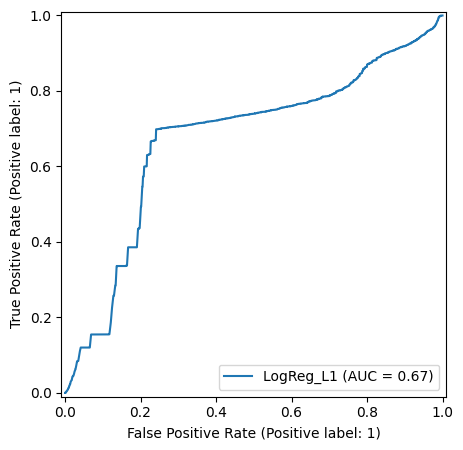

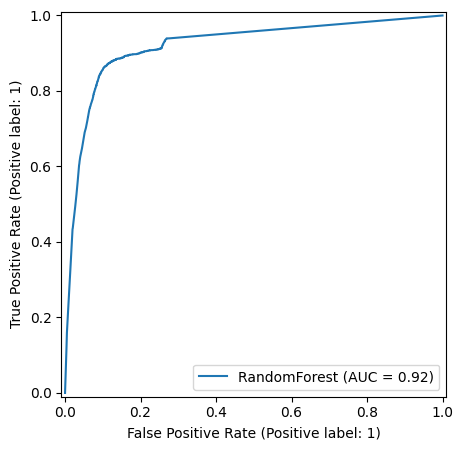

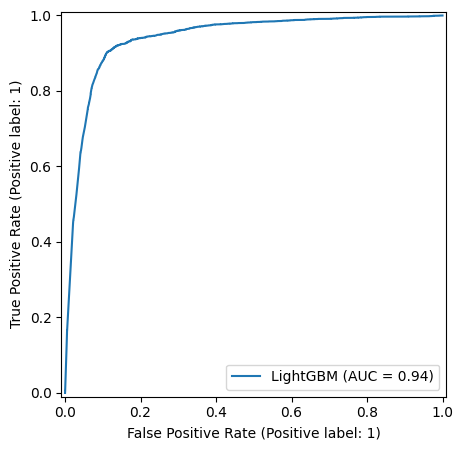

<Figure size 700x500 with 0 Axes>

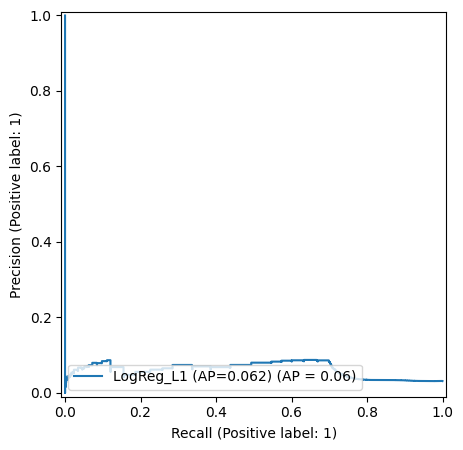

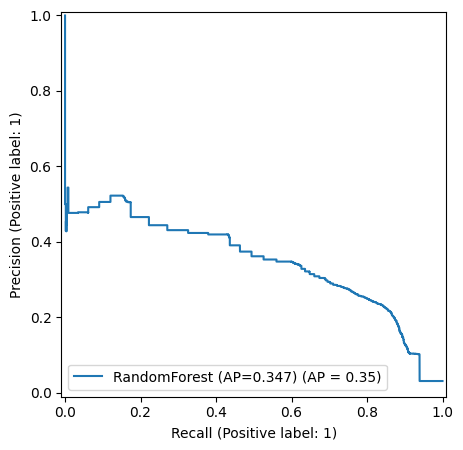

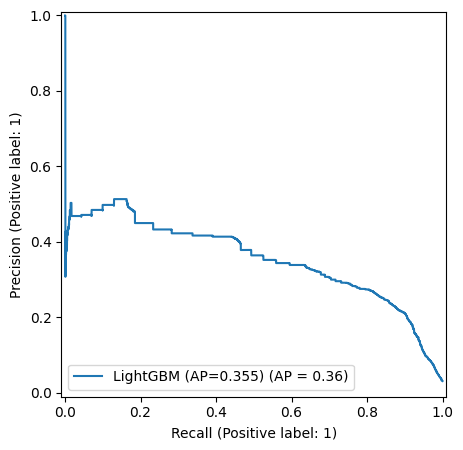

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

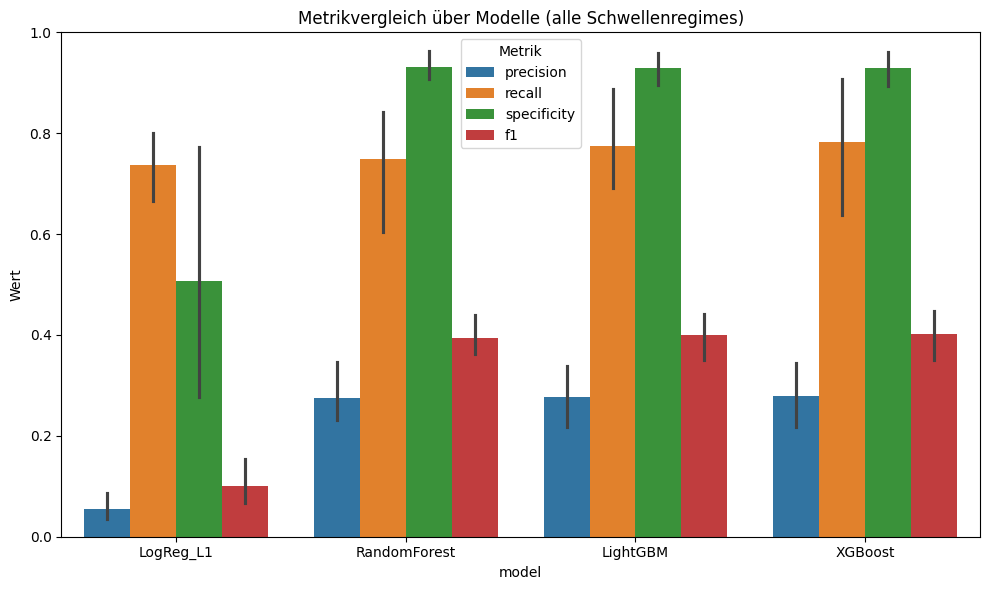

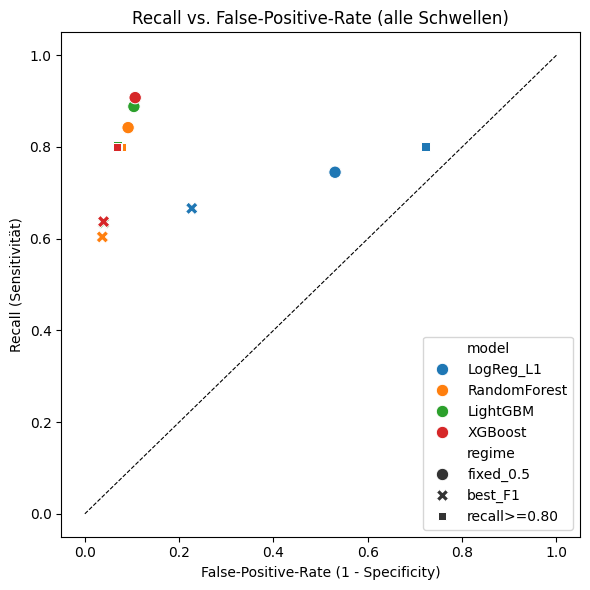

[OK] ROC/PR Plots gespeichert unter: analysis_outputs_100.000
[OK] Top Importances (RandomForest) gespeichert.
[LightGBM] [Info] Number of positive: 4190, number of negative: 128417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 132607, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[OK] Top Importances (LightGBM) gespeichert.
[OK] Top Importances (XGBoost) gespeichert.
[LightGBM] [Info] Number of positive: 4190, number of negative: 128417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

In [72]:
#13
# =========================
# 9) ERWEITERTE BASELINES: XGBoost & LightGBM + OOF-KURVEN + IMPORTANCES
# =========================


OUTDIR = Path(OUTDIR)
OUTDIR.mkdir(parents=True, exist_ok=True)

# --- Imbalance-Kennzahlen
n_pos = int((y_all == 1).sum())
n_neg = int((y_all == 0).sum())
pos_rate = n_pos / (n_pos + n_neg)
scale_pos_w = n_neg / max(n_pos, 1)

print(f"[Diag] Klassen: 1={n_pos}, 0={n_neg} (Pos-Rate={pos_rate:.3%}), "
      f"scale_pos_weight (für XGB) ≈ {scale_pos_w:.1f}")

# --- Modelle definieren (mit Preprocess in Pipeline)
lgbm = Pipeline([
    ("prep", preprocess),
    ("clf", LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,              # -1 = keine feste Tiefe
        num_leaves=64,             # moderat, gern tunen
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",   # oder: scale_pos_weight=scale_pos_w
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

xgb = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=700,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        eval_metric="logloss",
        scale_pos_weight=scale_pos_w,   # wichtig bei Imbalance!
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# --- CV: ROC-AUC wie zuvor
def cv_auc(label, model):
    aucs = cross_val_score(model, X_all, y_all, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{label} | AUC: {aucs.mean():.3f} ± {aucs.std():.3f}  (Folds: {np.round(aucs,3)})")
    return {"model": label, "mean_auc": aucs.mean(), "std_auc": aucs.std(), "fold_aucs": aucs}

lgbm_scores = cv_auc("LightGBM", lgbm)
xgb_scores  = cv_auc("XGBoost",  xgb)

# Ergebnisse an die vorhandene Tabelle anhängen und speichern
model_cv2 = pd.DataFrame([lgbm_scores, xgb_scores])
all_cv = pd.concat([model_cv, model_cv2], ignore_index=True)
all_cv.to_csv(OUTDIR / "model_cv_scores_extended.csv", index=False)
display(all_cv)

# --- OOF-Predictions für ROC/PR-Kurven (validiert, kein Leakage)
def oof_proba(model):
    # method='predict_proba' -> ndarray mit 2 Spalten; wir nehmen P(y=1)
    proba = cross_val_predict(model, X_all, y_all, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    return proba

oof = {}
oof["LogReg_L1"]    = oof_proba(logreg)
oof["RandomForest"] = oof_proba(rf)
oof["LightGBM"]     = oof_proba(lgbm)
oof["XGBoost"]      = oof_proba(xgb)

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

print("=== OOF-Diagnose ===")
for name, prob in oof.items():
    prob = np.asarray(prob)
    print(
        f"{name:12s} | len={len(prob):7d} | NaNs={np.isnan(prob).sum():5d} "
        f"| unique={len(np.unique(prob))} | min={np.nanmin(prob):.4f} | max={np.nanmax(prob):.4f}"
    )
    try:
        print(f"   AUC={roc_auc_score(y_all, prob):.3f} | AP={average_precision_score(y_all, prob):.3f}")
    except Exception as e:
        print(f"   [WARN] scoring failed: {e}")


# --- Kurven plotten und speichern
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score

def plot_roc_pr_curves_robust(oof_dict, y_true, outdir, title_suffix="OOF"):
    outdir.mkdir(exist_ok=True, parents=True)

    # --- Kombinierte ROC
    plt.figure()
    plotted_any = False
    for name, prob in oof_dict.items():
        try:
            RocCurveDisplay.from_predictions(y_true, prob, name=name)
            plotted_any = True
        except Exception as e:
            print(f"[SKIP ROC] {name}: {e}")
    if plotted_any:
        plt.title(f"ROC-Kurven ({title_suffix})")
        plt.tight_layout()
        plt.savefig(outdir / f"roc_{title_suffix.lower()}_combined.png", dpi=160)
    plt.close()

    # --- Kombinierte PR
    plt.figure()
    plotted_any = False
    for name, prob in oof_dict.items():
        try:
            ap = average_precision_score(y_true, prob)
            PrecisionRecallDisplay.from_predictions(y_true, prob, name=f"{name} (AP={ap:.3f})")
            plotted_any = True
        except Exception as e:
            print(f"[SKIP PR] {name}: {e}")
    if plotted_any:
        plt.title(f"Precision–Recall-Kurven ({title_suffix})")
        plt.tight_layout()
        plt.savefig(outdir / f"pr_{title_suffix.lower()}_combined.png", dpi=160)
    plt.close()

    # --- Einzelplots pro Modell (falls du die separat willst)
    for name, prob in oof_dict.items():
        # ROC einzeln
        try:
            plt.figure()
            RocCurveDisplay.from_predictions(y_true, prob, name=name)
            plt.title(f"ROC – {name} ({title_suffix})")
            plt.tight_layout()
            plt.savefig(outdir / f"roc_{title_suffix.lower()}_{name}.png", dpi=160)
            plt.close()
        except Exception as e:
            print(f"[SKIP single ROC] {name}: {e}")

        # PR einzeln
        try:
            ap = average_precision_score(y_true, prob)
            plt.figure()
            PrecisionRecallDisplay.from_predictions(y_true, prob, name=f"{name} (AP={ap:.3f})")
            plt.title(f"PR – {name} ({title_suffix})")
            plt.tight_layout()
            plt.savefig(outdir / f"pr_{title_suffix.lower()}_{name}.png", dpi=160)
            plt.close()
        except Exception as e:
            print(f"[SKIP single PR] {name}: {e}")

    print("[OK] ROC/PR Plots gespeichert.")

plot_roc_pr_curves_robust(oof, y_all, OUTDIR, title_suffix="OOF")





# ----- Helper: Metriken aus Konfusionsmatrix
def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0          # = Sensitivity (TPR)
    specificity = tn / (tn + fp) if (tn + fp) else 0.0        # = TNR
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0
    return dict(tp=tp, fp=fp, fn=fn, tn=tn,
                precision=precision, recall=recall, specificity=specificity, f1=f1)

# ----- Helper: Confusion-Matrix plotten & speichern
def save_confusion_matrix(y_true, y_pred, name, outdir):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix – {name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_xticklabels(["0 (kein Krebs)", "1 (Krebs)"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["0 (kein Krebs)", "1 (Krebs)"])
    # Zahlen eintragen
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    fig.savefig(outdir / f"cm_{name}.png", dpi=160)
    plt.close(fig)
    return cm

# ----- Helper: beste Schwelle nach F1 + Schwelle für gewünschte Recall-Rate
def pick_thresholds(y_true, probs, recall_target=0.90):
    precision, recall, thr = precision_recall_curve(y_true, probs)
    # precision_recall_curve gibt len(thr)=len(precision)-1
    f1 = (2*precision[:-1]*recall[:-1]) / (precision[:-1]+recall[:-1] + 1e-12)
    best_idx = np.nanargmax(f1)
    thr_best_f1 = thr[best_idx]
    f1_best = f1[best_idx]

    # kleinste Schwelle, die Recall >= recall_target liefert
    idxs = np.where(recall[:-1] >= recall_target)[0]
    thr_recall = thr[idxs[-1]] if len(idxs) else None  # letzte (größte) Schwelle, die das noch schafft
    return dict(thr_best_f1=float(thr_best_f1), f1_best=float(f1_best),
                thr_recall_target=float(thr_recall) if thr_recall is not None else None)

# ----- 1) Confusion-Matrices & Metriken erzeugen
summary_rows = []
confm_dir = OUTDIR / "confusion_matrices"
confm_dir.mkdir(exist_ok=True, parents=True)

# Falls XGBoost in oof fehlt, hier überspringen wir automatisch
for name, probs in oof.items():
    # a) Standard-0.5
    pred_05 = (probs >= 0.5).astype(int)
    cm_05 = save_confusion_matrix(y_all, pred_05, f"{name}_thr0_50", confm_dir)
    m_05 = metrics_from_cm(cm_05)
    m_05.update(model=name, threshold=0.50, regime="fixed_0.5")
    summary_rows.append(m_05)

    # b) Beste F1-Schwelle
    thrs = pick_thresholds(y_all, probs, recall_target=0.80)
    pred_best = (probs >= thrs["thr_best_f1"]).astype(int)
    cm_best = save_confusion_matrix(y_all, pred_best, f"{name}_bestF1_{thrs['thr_best_f1']:.3f}", confm_dir)
    m_best = metrics_from_cm(cm_best)
    m_best.update(model=name, threshold=thrs["thr_best_f1"], regime="best_F1")
    summary_rows.append(m_best)

    # c) (Optional) Recall-Ziel (z. B. 0.80)
    if thrs["thr_recall_target"] is not None:
        t_rec = thrs["thr_recall_target"]
        pred_rec = (probs >= t_rec).astype(int)
        cm_rec = save_confusion_matrix(y_all, pred_rec, f"{name}_recall>=0.80_{t_rec:.3f}", confm_dir)
        m_rec = metrics_from_cm(cm_rec)
        m_rec.update(model=name, threshold=t_rec, regime="recall>=0.80")
        summary_rows.append(m_rec)

# Tabelle speichern
cm_summary = pd.DataFrame(summary_rows)
cm_summary = cm_summary[["model","regime","threshold","tp","fp","fn","tn",
                         "precision","recall","specificity","f1"]]
cm_summary.to_csv(OUTDIR / "confusion_matrix_summary.csv", index=False)
print("[OK] Confusion matrices gespeichert unter:", confm_dir)
print("[OK] Zusammenfassung:", OUTDIR / "confusion_matrix_summary.csv")
cm_summary

# =========================
# 11) CONFUSION-MATRIX REPORTING & VISUALISIERUNG
# =========================


report_path = OUTDIR / "confusion_matrix_summary.csv"
cm_summary = pd.read_csv(report_path)

# Übersicht ausgeben
print("🔍 Zusammenfassung der Schwellen-Analysen:")
display(cm_summary.head())

# --- 1) Beste F1-Resultate pro Modell
best_f1 = (cm_summary[cm_summary["regime"] == "best_F1"]
           .sort_values("f1", ascending=False))
print("\n🏆 Beste F1-Werte pro Modell:")
display(best_f1[["model", "threshold", "precision", "recall", "specificity", "f1"]])

# --- 2) Visualisierung: Precision / Recall / F1 im Vergleich
melted = cm_summary.melt(
    id_vars=["model", "regime"],
    value_vars=["precision", "recall", "specificity", "f1"],
    var_name="metric", value_name="value"
)

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="model", y="value", hue="metric")
plt.title("Metrikvergleich über Modelle (alle Schwellenregimes)")
plt.ylim(0,1)
plt.ylabel("Wert")
plt.legend(title="Metrik")
plt.tight_layout()
plt.savefig(OUTDIR / "confusion_metric_comparison.png", dpi=160)
plt.show()

# --- 3) Recall vs. False-Positive-Rate (1 - Specificity)
cm_summary["fpr"] = 1 - cm_summary["specificity"]

plt.figure(figsize=(6,6))
sns.scatterplot(data=cm_summary, x="fpr", y="recall",
                hue="model", style="regime", s=80)
plt.plot([0,1], [0,1], "k--", lw=0.8)
plt.title("Recall vs. False-Positive-Rate (alle Schwellen)")
plt.xlabel("False-Positive-Rate (1 - Specificity)")
plt.ylabel("Recall (Sensitivität)")
plt.tight_layout()
plt.savefig(OUTDIR / "recall_vs_fpr.png", dpi=160)
plt.show()




print(f"[OK] ROC/PR Plots gespeichert unter: {OUTDIR}")

# --- (A) Modellinterne Feature-Importances (RF/LGBM/XGB)
'''
def get_feature_names_from_ct(ct):
    # Liefert die Spaltennamen nach dem ColumnTransformer
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            # z. B. Pipeline -> letzten Schritt prüfen
            try:
                fn = trans.get_feature_names_out(cols)
                names.extend(list(fn))
            except Exception:
                # Fallback: Originalspalten
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names
'''
# --- (A) Modellinterne Feature-Importances (robust)
# For our preprocessing (impute+scale only), transformed = input columns (1:1).
# So we can safely use the original column names.
def fit_full_and_importances(pipe, label):
    pipe.fit(X_all, y_all)
    clf = pipe.named_steps["clf"]
    feat_names = list(X_all.columns)

    if hasattr(clf, "feature_importances_"):
        importances = np.asarray(clf.feature_importances_)
        # Align defensively in case of any mismatch
        n = min(len(feat_names), len(importances))
        fi = pd.DataFrame({
            "feature": feat_names[:n],
            "importance": importances[:n]
        }).sort_values("importance", ascending=False).head(40)
        fi.to_csv(OUTDIR / f"feature_importance_{label}.csv", index=False)
        print(f"[OK] Top Importances ({label}) gespeichert.")
        return fi
    else:
        print(f"[HINWEIS] {label} hat kein feature_importances_.")
        return None


fi_rf  = fit_full_and_importances(rf,   "RandomForest")
fi_lgb = fit_full_and_importances(lgbm, "LightGBM")
fi_xgb = fit_full_and_importances(xgb,  "XGBoost")

# --- (B) Permutation Importance (modellagnostisch, aussagekräftig)
# Wir machen es exemplarisch für LightGBM (kannst du für andere Modelle wiederholen)
# --- (B) Permutation Importance (robust; uses INPUT feature names)
def permutation_importance_on_full(pipe, label, n_repeats=5):
    pipe.fit(X_all, y_all)

    # Base AUC (explorativ, fit-on-all). For stricter estimates, do it per CV fold.
    y_prob = pipe.predict_proba(X_all)[:, 1]
    base_auc = roc_auc_score(y_all, y_prob)

    r = permutation_importance(
        pipe, X_all, y_all,
        scoring="roc_auc", n_repeats=n_repeats,
        random_state=RANDOM_STATE, n_jobs=-1
    )

    feat_names = list(X_all.columns)
    imp_mean = np.asarray(r.importances_mean)
    imp_std  = np.asarray(r.importances_std)

    # Align lengths defensively
    n = min(len(feat_names), len(imp_mean), len(imp_std))
    if n != len(feat_names) or n != len(imp_mean):
        print(f"[WARN] Length mismatch: names={len(feat_names)}, "
              f"mean={len(imp_mean)}, std={len(imp_std)} -> truncated to {n}")

    pi = (pd.DataFrame({
            "feature": feat_names[:n],
            "importance_mean": imp_mean[:n],
            "importance_std": imp_std[:n],
        })
        .sort_values("importance_mean", ascending=False)
        .head(40)
    )
    pi.to_csv(OUTDIR / f"permutation_importance_{label}.csv", index=False)
    print(f"[OK] Permutation Importance ({label}) gespeichert. Base AUC (fit-on-all): {base_auc:.3f}")
    return pi


pi_lgb = permutation_importance_on_full(lgbm, "LightGBM", n_repeats=5)


[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3352, number of negative: 102733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 106085, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

<Figure size 700x500 with 0 Axes>

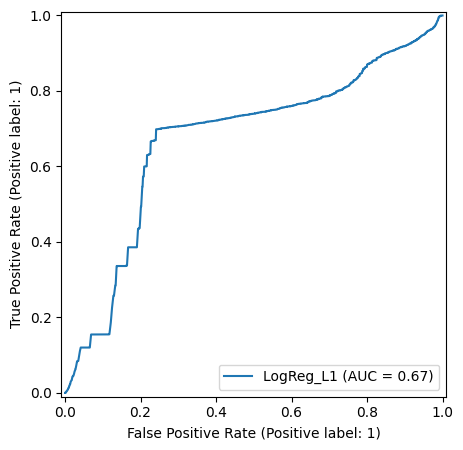

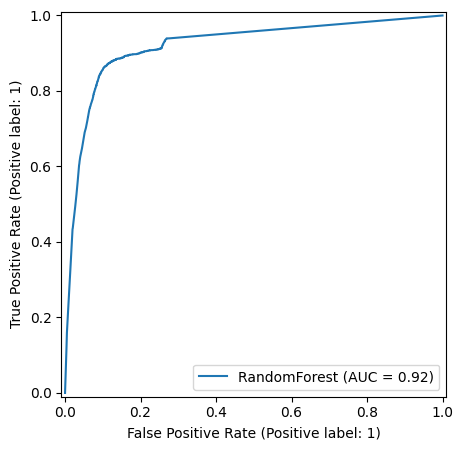

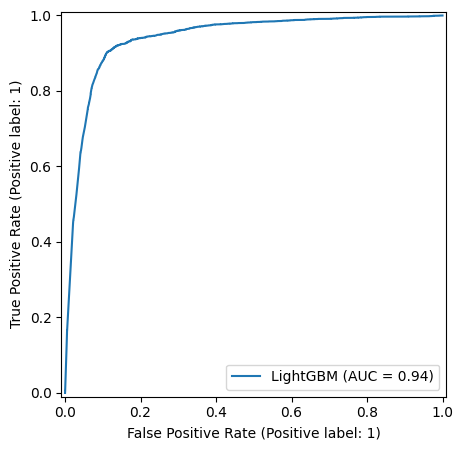

<Figure size 700x500 with 0 Axes>

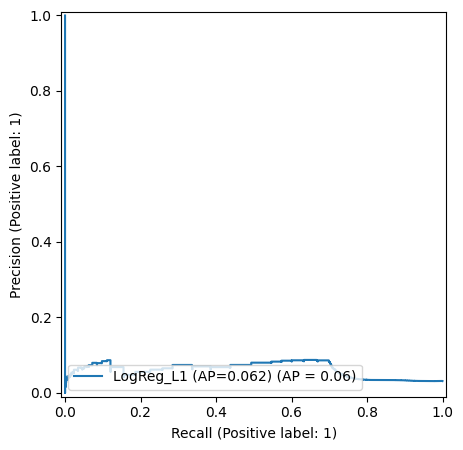

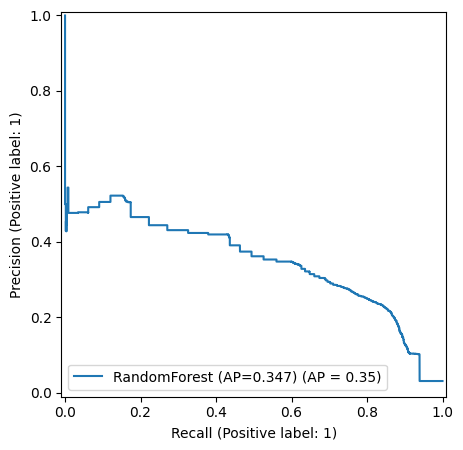

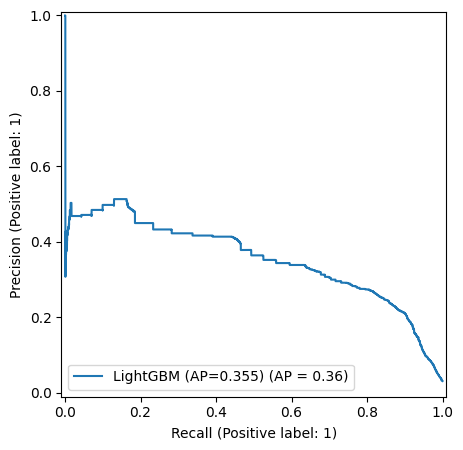

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [73]:
#14
# ============================================
# ROBUSTE OOF-DIAGNOSE + PLOTS + CONFUSION MATRICES (+ REPORT)
# ============================================


OUTDIR = Path(OUTDIR)
(OUTDIR / "confusion_matrices").mkdir(parents=True, exist_ok=True)

# ---- 0) Zielvariable hart absichern (binär, keine NaNs)
def ensure_binary_y_strict(y):
    y_ = pd.Series(y).copy()
    mapping = {True:1, False:0, "1":1, "0":0, 1:1, 0:0, "yes":1, "no":0, "ja":1, "nein":0}
    y_ = y_.map(lambda v: mapping.get(v, v))
    y_ = pd.to_numeric(y_, errors="coerce").fillna(0).astype(int)
    assert set(np.unique(y_)) <= {0,1}, "y must be binary {0,1}"
    return y_

y_all = ensure_binary_y_strict(y_all)

# ---- 1) OOF-Probas robust erzeugen
def oof_proba_generic(model, X, y, cv, force_serial=False):
    # Manchmal zickt XGB mit parallelem cross_val_predict -> Option seriell
    n_jobs = 1 if force_serial else -1
    proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=n_jobs)[:, 1]
    # NaN/Inf abfangen + auf (0,1) beschneiden
    proba = np.nan_to_num(proba, nan=0.0, posinf=1.0, neginf=0.0)
    proba = np.clip(proba, 1e-12, 1-1e-12)
    return proba

oof = {}
oof["LogReg_L1"]    = oof_proba_generic(logreg, X_all, y_all, cv)
oof["RandomForest"] = oof_proba_generic(rf,     X_all, y_all, cv)
oof["LightGBM"]     = oof_proba_generic(lgbm,   X_all, y_all, cv)
# XGBoost zur Sicherheit seriell laufen lassen
oof["XGBoost"]      = oof_proba_generic(xgb,    X_all, y_all, cv, force_serial=True)

# ---- 2) Mini-Diagnose: sind die Scores valide?
print("=== OOF-Diagnose ===")
for name, prob in oof.items():
    arr = np.asarray(prob)
    print(f"{name:12s} | n={arr.size:7d} | NaNs={np.isnan(arr).sum():5d} "
          f"| uniq={len(np.unique(arr))} | min={arr.min():.6f} | max={arr.max():.6f}")
    try:
        print(f"   AUC={roc_auc_score(y_all, arr):.3f} | AP={average_precision_score(y_all, arr):.3f}")
    except Exception as e:
        print(f"   [WARN] scoring failed: {e}")

# ---- 3) Robust: kombinierte + Einzel-ROC/PR Plots
def plot_roc_pr_curves_robust(oof_dict, y_true, outdir, title_suffix="OOF"):
    outdir.mkdir(exist_ok=True, parents=True)

    # Kombinierte ROC
    plt.figure()
    plotted = False
    for name, prob in oof_dict.items():
        try:
            RocCurveDisplay.from_predictions(y_true, prob, name=name)
            plotted = True
        except Exception as e:
            print(f"[SKIP ROC] {name}: {e}")
    if plotted:
        plt.title(f"ROC-Kurven ({title_suffix})")
        plt.tight_layout()
        plt.savefig(outdir / f"roc_{title_suffix.lower()}_combined.png", dpi=160)
    plt.close()

    # Kombinierte PR
    plt.figure()
    plotted = False
    for name, prob in oof_dict.items():
        try:
            ap = average_precision_score(y_true, prob)
            PrecisionRecallDisplay.from_predictions(y_true, prob, name=f"{name} (AP={ap:.3f})")
            plotted = True
        except Exception as e:
            print(f"[SKIP PR] {name}: {e}")
    if plotted:
        plt.title(f"Precision–Recall-Kurven ({title_suffix})")
        plt.tight_layout()
        plt.savefig(outdir / f"pr_{title_suffix.lower()}_combined.png", dpi=160)
    plt.close()

    # Einzelplots pro Modell
    for name, prob in oof_dict.items():
        try:
            plt.figure()
            RocCurveDisplay.from_predictions(y_true, prob, name=name)
            plt.title(f"ROC – {name} ({title_suffix})")
            plt.tight_layout()
            plt.savefig(outdir / f"roc_{title_suffix.lower()}_{name}.png", dpi=160)
            plt.close()
        except Exception as e:
            print(f"[SKIP single ROC] {name}: {e}")

        try:
            ap = average_precision_score(y_true, prob)
            plt.figure()
            PrecisionRecallDisplay.from_predictions(y_true, prob, name=f"{name} (AP={ap:.3f})")
            plt.title(f"PR – {name} ({title_suffix})")
            plt.tight_layout()
            plt.savefig(outdir / f"pr_{title_suffix.lower()}_{name}.png", dpi=160)
            plt.close()
        except Exception as e:
            print(f"[SKIP single PR] {name}: {e}")

plot_roc_pr_curves_robust(oof, y_all, OUTDIR, title_suffix="OOF")

# ---- 4) Confusion Matrices (0.5, beste F1, Recall-Target) + CSV-Report
def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0          # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) else 0.0        # True Negative Rate
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0
    return dict(tp=tp, fp=fp, fn=fn, tn=tn,
                precision=precision, recall=recall, specificity=specificity, f1=f1)

def save_confusion_matrix(y_true, y_pred, name, outdir):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix – {name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_xticklabels(["0 (kein Krebs)","1 (Krebs)"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["0 (kein Krebs)","1 (Krebs)"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    fig.savefig(outdir / f"cm_{name}.png", dpi=160)
    plt.close(fig)
    return cm

def pick_thresholds(y_true, probs, recall_target=0.90):
    precision, recall, thr = precision_recall_curve(y_true, probs)
    f1 = (2*precision[:-1]*recall[:-1]) / (precision[:-1]+recall[:-1] + 1e-12)
    best_idx = int(np.nanargmax(f1))
    thr_best_f1 = float(thr[best_idx])
    f1_best = float(f1[best_idx])
    idxs = np.where(recall[:-1] >= recall_target)[0]
    thr_recall = float(thr[idxs[-1]]) if len(idxs) else None
    return dict(thr_best_f1=thr_best_f1, f1_best=f1_best, thr_recall_target=thr_recall)

summary_rows = []
confm_dir = OUTDIR / "confusion_matrices"

for name, probs in oof.items():
    # (a) feste Schwelle 0.5
    pred_05 = (probs >= 0.5).astype(int)
    cm_05   = save_confusion_matrix(y_all, pred_05, f"{name}_thr0_50", confm_dir)
    m_05    = metrics_from_cm(cm_05); m_05.update(model=name, threshold=0.50, regime="fixed_0.5")
    summary_rows.append(m_05)

    # (b) beste F1-Schwelle
    thrs    = pick_thresholds(y_all, probs, recall_target=0.90)
    pred_b  = (probs >= thrs["thr_best_f1"]).astype(int)
    cm_b    = save_confusion_matrix(y_all, pred_b, f"{name}_bestF1_{thrs['thr_best_f1']:.3f}", confm_dir)
    m_b     = metrics_from_cm(cm_b); m_b.update(model=name, threshold=thrs["thr_best_f1"], regime="best_F1")
    summary_rows.append(m_b)

    # (c) Recall-Ziel (z. B. ≥ 0.80), falls erreichbar
    if thrs["thr_recall_target"] is not None:
        t_rec  = thrs["thr_recall_target"]
        pred_r = (probs >= t_rec).astype(int)
        cm_r   = save_confusion_matrix(y_all, pred_r, f"{name}_recall>=0.90_{t_rec:.3f}", confm_dir)
        m_r    = metrics_from_cm(cm_r); m_r.update(model=name, threshold=t_rec, regime="recall>=0.90")
        summary_rows.append(m_r)

cm_summary = pd.DataFrame(summary_rows)[
    ["model","regime","threshold","tp","fp","fn","tn","precision","recall","specificity","f1"]
]
cm_summary.to_csv(OUTDIR / "confusion_matrix_summary.csv", index=False)
print("[OK] Confusion matrices gespeichert nach:", confm_dir)
print("[OK] Zusammenfassung:", OUTDIR / "confusion_matrix_summary.csv")

# ---- 5) Kleines Reporting (ohne seaborn)
# Balkenvergleich der Metriken (alle Regimes)
metrics = ["precision","recall","specificity","f1"]
models = cm_summary["model"].unique()

for metric in metrics:
    plt.figure(figsize=(10,4))
    # einfache gruppierte Balken per Matplotlib
    regimes = cm_summary["regime"].unique()
    x = np.arange(len(models))
    width = 0.8 / len(regimes)
    for i, reg in enumerate(regimes):
        vals = [cm_summary[(cm_summary.model==m)&(cm_summary.regime==reg)][metric].mean() if not
                cm_summary[(cm_summary.model==m)&(cm_summary.regime==reg)].empty else 0.0
                for m in models]
        plt.bar(x + i*width, vals, width=width, label=reg)
    plt.xticks(x + (len(regimes)-1)*width/2, models, rotation=0)
    plt.ylim(0,1)
    plt.ylabel(metric)
    plt.title(f"{metric} – Vergleich nach Modell & Regime")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTDIR / f"report_{metric}.png", dpi=160)
    plt.close()


In [74]:
#15
# =========================
# 9) RFECV mit LogReg-L1
# =========================
# Achtung: RFECV kann dauern – wähle ggf. kleinere max_features


base_log = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", random_state=RANDOM_STATE, max_iter=200))
])

# RFECV braucht schätzbar Feature-Namen nach Preprocessing:
# Wir wenden RFECV "außen" an, indem wir nach Preprocessing auf die transformierten
# Spalten gehen. Vereinfachung: Wir führen RFECV auf den "rohen" Spalten mit einem
# einfachen Imputer+Scaler separat durch.

simp_pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("bin", SimpleImputer(strategy="most_frequent"), bin_cols),
    ],
    remainder="drop"
)

X_mat = simp_pre.fit_transform(df[sel_nonredundant])
feat_names = np.array(num_cols + bin_cols)

est = LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", random_state=RANDOM_STATE, max_iter=200)
rfecv = RFECV(estimator=est, step=1, cv=cv, scoring="roc_auc", n_jobs=None)
rfecv.fit(X_mat, y)

support = rfecv.support_
ranking = rfecv.ranking_
selected_rfecv = feat_names[support].tolist()

pd.DataFrame({
    "Feature": feat_names,
    "RFECV_Selected": support,
    "RFECV_Rank": ranking
}).sort_values(["RFECV_Selected","RFECV_Rank"], ascending=[False, True]).to_csv(OUTDIR / "rfecv_selection.csv", index=False)

print("RFECV ausgewählt:", len(selected_rfecv))
selected_rfecv[:30]


RFECV ausgewählt: 7


['num_procedures',
 'num_medications',
 'num_encounters',
 'has_allergy',
 'Diabetic diet',
 'Td (adult) preservative free',
 'Chronic sinusitis (disorder)']

4 Verschiedene Coverage Werte ausprobieren

In [75]:
'''# === 15) COVERAGE-EXPERIMENTE (20%, 40%, 100%) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

RANDOM_STATE = 42
COVERAGES = [0.20, 0.40, 1.00]  # 100% = 1.00
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def compute_coverage(X: pd.DataFrame):
    return 1.0 - X.isna().mean()

def metrics_from_preds(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    specificity = tn / (tn + fp + 1e-12)
    f1        = (2*precision*recall)/(precision+recall+1e-12)
    acc       = (tp + tn) / (tp + tn + fp + fn)
    auc       = roc_auc_score(y_true, y_proba)
    return dict(tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn),
                precision=float(precision), recall=float(recall),
                specificity=float(specificity), f1=float(f1), accuracy=float(acc), auc=float(auc))

def best_f1_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1_arr = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1] + 1e-12)
    t_best = thr[np.argmax(f1_arr)]
    return float(t_best)

def recall_target_threshold(y_true, proba, target=0.80):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    idxs = np.where(rec[:-1] >= target)[0]
    return float(thr[idxs[-1]]) if len(idxs) else None

models = {
    "LogReg_L1": Pipeline([("prep", preprocess),
                           ("clf", LogisticRegression(penalty="l1", solver="liblinear",
                                                      class_weight="balanced",
                                                      random_state=RANDOM_STATE, max_iter=200))]),
    "RandomForest": Pipeline([("prep", preprocess),
                              ("clf", RandomForestClassifier(n_estimators=400,
                                                            class_weight="balanced_subsample",
                                                            random_state=RANDOM_STATE))]),
    "LightGBM": Pipeline([("prep", preprocess),
                          ("clf", lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05,
                                                     num_leaves=31, class_weight="balanced",
                                                     random_state=RANDOM_STATE))]),
    "XGBoost": Pipeline([("prep", preprocess),
                         ("clf", xgb.XGBClassifier(n_estimators=400, learning_rate=0.05,
                                                   max_depth=6, subsample=0.9, colsample_bytree=0.9,
                                                   eval_metric="logloss", random_state=RANDOM_STATE))]),
}

rows = []
cov_map = compute_coverage(X_all)

for cov_thr in COVERAGES:
    sel_cov = cov_map[cov_map >= cov_thr].index.tolist()
    if len(sel_cov) < 3:
        print(f"[WARN] coverage {cov_thr:.2f}: nur {len(sel_cov)} Features – wird übersprungen.")
        continue
    X_sub = X_all[sel_cov]

    for model_name, pipe in models.items():
        proba = cross_val_predict(pipe, X_sub, y_all, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

        regimes = {"fixed_0.5": 0.5}
        t_best = best_f1_threshold(y_all, proba)
        regimes["best_F1"] = t_best
        t_r80 = recall_target_threshold(y_all, proba, 0.80)
        if t_r80 is not None:
            regimes["recall>=0.80"] = t_r80

        for reg, thr in regimes.items():
            y_pred = (proba >= thr).astype(int)
            metrics = metrics_from_preds(y_all, y_pred, proba)
            rows.append({
                "coverage": cov_thr,
                "n_features": len(sel_cov),
                "model": model_name,
                "regime": reg,
                "threshold": float(thr),
                **metrics
            })

results_cov = pd.DataFrame(rows)
display(results_cov.sort_values(["coverage","model","regime"]))
# results_cov.to_csv("coverage_experiments_summary.csv", index=False)
'''

'# === 15) COVERAGE-EXPERIMENTE (20%, 40%, 100%) ===\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import StratifiedKFold, cross_val_predict\nfrom sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import RandomForestClassifier\nimport lightgbm as lgb\nimport xgboost as xgb\n\nRANDOM_STATE = 42\nCOVERAGES = [0.20, 0.40, 1.00]  # 100% = 1.00\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)\n\ndef compute_coverage(X: pd.DataFrame):\n    return 1.0 - X.isna().mean()\n\ndef metrics_from_preds(y_true, y_pred, y_proba):\n    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()\n    precision = tp / (tp + fp + 1e-12)\n    recall    = tp / (tp + fn + 1e-12)\n    specificity = tn / (tn + fp + 1e-12)\n    f1        = (2*precision*recall)/(precision+recall+1e-12)\n    acc       = (tp + tn) / (tp + tn 

In [76]:
#16
import shap
# =========================
# 10) (Optional) SHAP Importance (falls 'shap' vorhanden)
# =========================
if HAS_SHAP:
    # Train finaler RandomForest auf allen Daten (mit Preprocessing)
    final_rf = Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced_subsample"))
    ]).fit(df[sel_nonredundant], y)

    # SHAP Explanations
    try:
        explainer = shap.Explainer(final_rf.named_steps["clf"])
        X_prep = final_rf.named_steps["prep"].transform(df[sel_nonredundant])
        shap_values = explainer(X_prep)
        # Hinweis: SHAP erzeugt eigene Plots; wenn du Speichern willst:
        # shap.plots.beeswarm(shap_values)  # ggf. interaktiv anzeigen
        # Statt Plot: mittlere |SHAP|-Werte als Tabelle
        mean_abs = np.abs(shap_values.values).mean(axis=0)
        shap_importance = pd.DataFrame({
            "Feature(preprocessed_idx)": np.arange(len(mean_abs)),
            "mean_abs_shap": mean_abs
        }).sort_values("mean_abs_shap", ascending=False)
        shap_importance.to_csv(OUTDIR / "shap_importance_preprocessed.csv", index=False)
        print("SHAP-Importance gespeichert (preprocessed Indizes).")
    except Exception as e:
        print("SHAP konnte nicht berechnet werden:", e)
else:
    print("SHAP nicht installiert – Schritt übersprungen.")


SHAP konnte nicht berechnet werden: Per-column arrays must each be 1-dimensional


In [77]:


# ========= 1) WELCHE PIPELINE NUTZEN? ==================
PIPE = rf            # <-- oder logreg
MODEL_NAME = "RandomForest" if PIPE is rf else "LogReg_L1"

# ========= 2) DATEN SETZEN ==============================
# X_used: Die Roh-Features, die zur Pipeline passen (z. B. X, Xc[sel_clean], df[sel_nonredundant] ...)
# y: Zielvariable (0/1)
# Beispiel (anpassen, falls anders benannt):
# X_used = Xc[sel_clean]

# Sicherheit: falls Pipeline noch nicht trainiert wurde
try:
    getattr(PIPE.named_steps["clf"], "classes_")
except Exception:
    PIPE.fit(X_used, y)

preprocessor = PIPE.named_steps["prep"]
model        = PIPE.named_steps["clf"]

# ========= 3) FEATURE-NAMEN NACH PREPROCESSING =========
# funktioniert ab sklearn >=1.0
feat_names_pre = preprocessor.get_feature_names_out()
X_pre = preprocessor.transform(X_used)

# ========= 4) SHAP-EXPLAINER ROBUST AUFSETZEN ==========
# Erst versuchen wir direkt die Pipeline zu erklären (shap.Explainer kann das häufig),
# sonst fallback: nur den Klassifikator + bereits transformierte Daten
try:
    explainer = shap.Explainer(PIPE, X_used)
    sv = explainer(X_used)
except Exception:
    # Baummodelle -> TreeExplainer, Lineare -> LinearExplainer
    try:
        explainer = shap.TreeExplainer(model)
    except Exception:
        explainer = shap.Explainer(model, X_pre)   # generischer Fallback
    sv = explainer(X_pre)

# ========= 5) SHAP-WERTE SAUBER AUSPACKEN ===============
vals = getattr(sv, "values", sv)  # Explanation.values oder rohes Array
# Bei Klassifikation kommt manchmal 3D (n, d, n_classes) -> wir nehmen Klasse 1
if isinstance(vals, np.ndarray) and vals.ndim == 3:
    vals = vals[..., 1]

# Längencheck
if len(feat_names_pre) != vals.shape[1]:
    raise ValueError(f"Längen passen nicht: SHAP-Dimension {vals.shape[1]} vs. Feature-Namen {len(feat_names_pre)}")

# ========= 6) MITTLERE |SHAP| JE TRANSFORMIERTEM FEAT. ==
mean_abs = np.abs(vals).mean(axis=0)
shap_df_pre = (pd.DataFrame({"feature_pre": feat_names_pre,
                             "mean_abs_shap": mean_abs})
               .sort_values("mean_abs_shap", ascending=False))

print("Top (transformierte) Features:")
display(shap_df_pre.head(20))

# ========= 7) ONE-HOT AUF URSPRUNGSSPALTE AGGREGIEREN ===
# Heuristik: ColumnTransformer benennt i.d.R. wie "<alias>__<spalte>_<kategorie>" (bei OHE)
orig_names = []
for f in shap_df_pre["feature_pre"]:
    # Teil nach dem Transformer-Alias
    right = f.split("__", 1)[-1]
    # bei One-Hot trennen Kategorie am letzten Unterstrich:
    parts = right.rsplit("_", 1)
    orig = parts[0] if len(parts) == 2 else right
    orig_names.append(orig)

shap_df_pre["feature_orig"] = orig_names

shap_df_agg = (shap_df_pre.groupby("feature_orig", as_index=False)["mean_abs_shap"]
               .sum()
               .sort_values("mean_abs_shap", ascending=False))

print("Top (aggregiert auf Ursprungs-Features):")
display(shap_df_agg.head(25))

# ========= 8) OPTIONAL: PLOTS ===========================
# 8a) Summary-Plot (transformierte Features)
try:
    shap.summary_plot(vals, features=X_pre, feature_names=feat_names_pre, show=True)
except Exception as e:
    print("[WARN] summary_plot nicht möglich:", e)

# 8b) Bar-Plot (aggregierte Importance, nur Tabelle -> wir plotten mit Matplotlib)
topk = 20
plt.figure()
to_plot = shap_df_agg.head(topk).iloc[::-1]  # reverse für hübschen horizontalen Plot
plt.barh(to_plot["feature_orig"], to_plot["mean_abs_shap"])
plt.title(f"SHAP Importance (aggregiert) – Top {topk} – {MODEL_NAME}")
plt.xlabel("mean(|SHAP|)")
plt.tight_layout()
plt.show()

# ========= 9) EXPORT ==============================
shap_df_pre.to_csv("shap_importance_transformed.csv", index=False)
shap_df_agg.to_csv("shap_importance_aggregated.csv", index=False)
print("Gespeichert: shap_importance_transformed.csv, shap_importance_aggregated.csv")

NameError: name 'X_used' is not defined

In [ ]:


# Annahmen:
# - preprocessor: ColumnTransformer
# - model: finaler Klassifikator (z. B. LogReg oder RF)
# - pipe: Pipeline(preprocessor, model)  ODER X_pre = preprocessor.fit_transform(X)
# - X_pre: transformierte Matrix, passend zu feat_names_pre
# - feat_names_pre: Liste der Spaltennamen nach dem Preprocess
# - y: Zielvariable (für binary classification)

# 1) Feature-Namen nach dem Preprocess sicher ermitteln
feat_names_pre = preprocessor.get_feature_names_out()
X_pre = preprocessor.transform(X)  # falls noch nicht geschehen

# 2) SHAP-Explainer robust aufsetzen
# Für lineare Modelle / Tree-Modelle:
try:
    explainer = shap.Explainer(pipe, X)          # geht oft direkt mit Pipeline
    sv = explainer(X)                             # SHAP Explanation
except Exception:
    # Fallback: Erkläre das bereits transformierte X_pre + reinen Klassifikator
    explainer = shap.Explainer(model, X_pre)
    sv = explainer(X_pre)

# 3) Werte-Array aus der Explanation holen
vals = getattr(sv, "values", sv)  # sv.values wenn Explanation; sonst sv (z. B. numpy)

# 4) Falls predict_proba erklärt wurde, kommen 3D-Werte (n_samples, n_features, n_classes).
#    Wir nehmen Klasse 1 (positiv):
if isinstance(vals, np.ndarray) and vals.ndim == 3:
    vals = vals[..., 1]

# 5) Mittlere |SHAP|-Beiträge pro transformiertem Feature
mean_abs = np.abs(vals).mean(axis=0)

# 6) Sicherheitscheck auf Länge
assert len(mean_abs) == len(feat_names_pre), \
    f"Längen passen nicht: mean_abs={len(mean_abs)} vs feat_names_pre={len(feat_names_pre)}"

# 7) Tabelle bauen
shap_df_pre = pd.DataFrame({
    "feature_pre": feat_names_pre,
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)
shap_df_pre.head(20)


NameError: name 'preprocessor' is not defined

In [ ]:
# =========================
# 11) ALLES ALS EXCEL SAMMELN
# =========================
with pd.ExcelWriter(OUTDIR / "feature_analysis_summary.xlsx") as writer:
    coverage_df.to_excel(writer, sheet_name="Coverage_Selected", index=False)
    uni_df.to_excel(writer, sheet_name="Univariate", index=False)
    model_cv.to_excel(writer, sheet_name="CV_Scores", index=False)
    pd.DataFrame({"Selected_Features": sel_nonredundant}).to_excel(writer, sheet_name="After_Redundancy", index=False)
    if Path(OUTDIR / "rfecv_selection.csv").exists():
        read_csv_robust(OUTDIR / "rfecv_selection.csv").to_excel(writer, sheet_name="RFECV", index=False)

print("Export fertig →", (OUTDIR / "feature_analysis_summary.xlsx").resolve())


Export fertig → C:\Users\Mein PC\Desktop\analysis_outputs\feature_analysis_summary.xlsx


# Parkbereich

Momentan nicht genutze code snippets

# 🧹 CSV Row Cleaner & Validator — Explanation

This script scans a CSV file (like **Synthea’s `patients.csv`**) for malformed rows — e.g., rows with too many or too few comma-separated columns — and removes them while logging which lines were skipped.  
It then writes a new, “fixed” CSV file that can be safely loaded into pandas or PyArrow without misaligned columns.

---

## 📄 Full Code

```python
import csv, pathlib

src   = pathlib.Path("/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients.csv")
fixed = src.with_name("patients_fixed.csv")
log   = src.with_name("patients_badrows.txt")

kept = skipped = 0
with src.open("r", encoding="utf-8", newline="") as fin, \
     fixed.open("w", encoding="utf-8", newline="") as fout, \
     log.open("w", encoding="utf-8") as flog:
    reader = csv.reader(fin, delimiter=",", quotechar='"', doublequote=True)
    writer = csv.writer(fout, delimiter=",", quotechar='"', doublequote=True, lineterminator="\n")
    for i, row in enumerate(reader, 1):
        if i == 1:                     # header
            writer.writerow(row); kept += 1; continue
        if len(row) == 17:
            writer.writerow(row); kept += 1
        else:
            flog.write(f"{i}\t{len(row)}\t{row[:3]} ...\n")
            skipped += 1

print(f"kept={kept}, skipped={skipped}, fixed={fixed}")


In [ ]:
#quick sanity check for the completeness of the patients.csv file
'''
import pandas as pd

path = "/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients.csv"

# Read robustly: no dtype guessing, no NA auto-detection, explicit comma delimiter
patients = pd.read_csv(
    path,
    dtype=str,                # keep everything as string
    keep_default_na=False,    # don't treat strings like 'NA' as NaN
    na_filter=False,          # don't convert empty fields to NaN
    sep=",",                  # explicit delimiter
    engine="python",          # more forgiving parser
    quoting=0                 # csv.QUOTE_MINIMAL; avoids odd quoting surprises
)

cols = ['BIRTHDATE', 'RACE', 'GENDER', 'ETHNICITY']

for col in cols:
    # count values that are not empty after stripping whitespace
    count = patients[col].str.strip().ne("").sum()
    total = len(patients)
    print(f"{col}: {count:,} of {total:,} rows present ({count/total:.2%})")
    '''

In [ ]:
'''
# Force the conservative parser for patients.csv only
patients = read_csv_robust(
    '/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients.csv',          # or the explicit path
    prefer_pyarrow=False,            # <- important
    dtype=str,
    keep_default_na=False,
    na_filter=False,
    sep=",",
    engine="python",
    quoting=0                        # csv.QUOTE_MINIMAL
)'''
'''
import pandas as pd

patients = pd.read_csv(
    "/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients.csv",
    dtype=str,              # keep raw text
    keep_default_na=False,  # don't convert strings like "NA" to NaN
    na_filter=False,        # keep empty fields as empty strings
    sep=",",
    engine="python",        # tolerant of messy quoting/newlines
    quotechar='"',          # default; keep explicit
    doublequote=True,       # default; keep explicit
    on_bad_lines="error"    # crash instead of silently mangling rows
)
'''

In [ ]:
'''
import csv

bad_lines = []
with open("/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients_fixed.csv", "r", encoding="utf-8", newline="") as f:
    reader = csv.reader(f, delimiter=",", quotechar='"', doublequote=True)
    for i, row in enumerate(reader, 1):
        if len(row) != 17:
            bad_lines.append((i, len(row)))
print(f"Bad lines: {len(bad_lines)}")
# If > 0, the file has malformed rows; you can log them or preclean.
'''

In [ ]:
'''
# Print all items in bad_lines
print(f"Total bad_lines: {len(bad_lines)}")
for item in bad_lines:
    print(item)
'''

In [ ]:
'''
import pandas as pd
from pathlib import Path

# Ordnerpfad anpassen
csv_dir = Path("/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv")

results = []

for f in csv_dir.glob("*.csv"):
    try:
        df = pd.read_csv(
            f,
            dtype=str,
            keep_default_na=False,
            na_filter=False,
            sep=",",
            engine="python",
            quoting=0
        )
        if "CODE" in df.columns:
            n_unique = df["CODE"].nunique()
            results.append((f.name, n_unique))
            print(f"✅ {f.name}: {n_unique:,} unique CODEs")
        else:
            print(f"⚪ {f.name}: keine Spalte 'CODE'")
    except Exception as e:
        print(f"❌ Fehler beim Lesen von {f.name}: {e}")

# Optional: Ergebnis in DataFrame speichern
summary = pd.DataFrame(results, columns=["Datei", "Unique_CODEs"])
summary.to_csv("/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/unique_codes_summary.csv", index=False)
print("\n📄 Zusammenfassung gespeichert unter:", "/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/Additional_Files/unique_codes_summary.csv")
'''

In [ ]:
'''
import csv

path = "/home/fgimkiew/synthea-parquet-pipeline/data/100.000CSV/csv/patients_fixed.csv"

bad = []
with open(path, "r", encoding="utf-8", newline="") as f:
    reader = csv.reader(f, delimiter=",", quotechar='"', doublequote=True)
    for i, row in enumerate(reader, 1):
        if len(row) != 17:          # patients.csv has exactly 17 columns
            bad.append((i, len(row)))
            if len(bad) >= 20:
                break

print(f"Bad lines found: {len(bad)}", bad[:5])
'''

In [ ]:
'''
expected = ['ID','BIRTHDATE','DEATHDATE','SSN','DRIVERS','PASSPORT',
            'PREFIX','FIRST','LAST','SUFFIX','MAIDEN','MARITAL',
            'RACE','ETHNICITY','GENDER','BIRTHPLACE','ADDRESS']

print("Shape:", patients.shape)  # should be (N, 17)
print("Columns match:", patients.columns.tolist() == expected)

# IDs should look like UUIDs (contain dashes)
print("Share of rows with UUID-like ID:", patients['ID'].str.contains("-").mean())

# Quick sample of the 5 key columns
print(patients[['ID','BIRTHDATE','GENDER','RACE','ETHNICITY']].head(5).to_string(index=False))
'''

In [ ]:
'''
# Expected header order for Synthea patients.csv (17 columns)
expected = ['ID','BIRTHDATE','DEATHDATE','SSN','DRIVERS','PASSPORT',
            'PREFIX','FIRST','LAST','SUFFIX','MAIDEN','MARITAL',
            'RACE','ETHNICITY','GENDER','BIRTHPLACE','ADDRESS']

print("Shape:", patients.shape)                # should be (N, 17)
print("Columns match:", patients.columns.tolist() == expected)

# check a few rows — the 5 key columns should look sane
print(patients[['ID','BIRTHDATE','GENDER','RACE','ETHNICITY']].head(5).to_string(index=False))
'''

In [ ]:
'''
patients_df = (
    patients[['ID','BIRTHDATE','GENDER','RACE','ETHNICITY']]
    .rename(columns={'ID':'PATIENT'})
    .astype('string')   # keep as strings; don't coerce to numeric
)
print(patients_df.head().to_string(index=False))
'''

In [ ]:
'''
import pandas as pd

# Step 1: Load your original DataFrame (replace with your actual loading logic)
# Example: df = read_csv_robust('your_data.csv')

# Step 2: Count non-NaN values per feature
feature_counts = df.notna().sum()

# Step 3: Select the top 216 features
top_216_features = feature_counts.sort_values(ascending=False).head(216).index.tolist()

# Step 4: Extract those columns into a new DataFrame
df_top216 = df[top_216_features]

# Step 5: Save the reduced DataFrame to CSV
df_top216.to_csv('/home/fgimkiew/synthea-parquet-pipeline/notebooks/checkpoints/100.000_top_features.csv', index=False)

print("✅ Extracted top 216 features and saved to 'top_216_features.csv'")
'''

In [ ]:
'''
# Dateipfade anpassen
datei_a = "C:/Users/Mein PC/Desktop/alle features Zeilenweise.txt"     # Enthält alle Features (eine Zeile pro Feature)
datei_b = "C:/Users/Mein PC/Desktop/187features.txt" # Enthält bekannte Features
datei_c = "C:/Users/Mein PC/Desktop/fehlende_features.txt" # Ziel: hier werden die fehlenden Features gespeichert

# Einlesen von Datei A
with open(datei_a, "r", encoding="utf-8") as f:
    alle_features = [line.strip() for line in f if line.strip()]

# Einlesen von Datei B
with open(datei_b, "r", encoding="utf-8") as f:
    vorhandene_features = set(line.strip() for line in f if line.strip())

# Vergleichen und fehlende Features ermitteln
fehlende_features = [feature for feature in alle_features if feature not in vorhandene_features]

# Speichern in Datei C
with open(datei_c, "w", encoding="utf-8") as f:
    for feature in fehlende_features:
        f.write(feature + "\n")

print(f"✅ {len(fehlende_features)} fehlende Features gefunden und gespeichert in '{datei_c}'.")
'''

In [ ]:
'''
# Dateinamen anpassen
file_a = "C:/Users/Mein PC/Desktop/alle features Zeilenweise.txt"
file_b = "C:/Users/Mein PC/Desktop/187features.txt"

# Zeilen zählen
def count_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return sum(1 for line in f if line.strip())

# Zählen
count_a = count_lines(file_a)
count_b = count_lines(file_b)

# Ausgabe
print(f"📄 '{file_a}' enthält {count_a} nicht-leere Zeilen.")
print(f"📄 '{file_b}' enthält {count_b} nicht-leere Zeilen.")
print(f"➡️ Differenz: {count_a - count_b}")
'''

In [ ]:
'''
import pandas as pd

# 1. Dateien laden
excel_features_path = "C:/Users/Mein PC/Desktop/Gefilterte_Features_Liste_152.xlsx"
csv_data_path = "C:/Users/Mein PC/Desktop/top_216_features.csv"

df_features = pd.read_excel(excel_features_path)
df_features.columns = df_features.columns.str.strip()

df_data = read_csv_robust(csv_data_path)

# 2. Liste der Features aus der Excel-Datei holen
features_list = df_features['Feature'].tolist()

# 3. Abdeckungsrate und Häufigkeit berechnen
total_patients = len(df_data)
coverage_results = []

for feature in features_list:
    if feature in df_data.columns:
        count_non_null = df_data[feature].notna().sum()
        coverage_rate = count_non_null / total_patients
        coverage_results.append((feature, count_non_null, coverage_rate))
    else:
        coverage_results.append((feature, 0, 0))

# 4. DataFrame mit den Ergebnissen erstellen
df_coverage = pd.DataFrame(coverage_results, columns=['Feature', 'Häufigkeit', 'Abdeckungsrate'])

# 5. Mit Original-Excel mergen
df_final = df_features.merge(df_coverage, on='Feature', how='left')

# 6. Ergebnis speichern
df_final.to_excel("C:/Users/Mein PC/Desktop/Gefilterte_Features_Liste_152_mit_Coverage.xlsx", index=False)
'''

In [ ]:
'''
def count_nonempty(df, columns):
    """Utility to quickly audit presence of data in key columns."""
    results = []
    total = len(df)
    for col in columns:
        if col not in df.columns:
            results.append((col, 0, total, 0.0, "MISSING COLUMN"))
            continue
        count = df[col].astype(str).str.strip().ne("").sum()
        results.append((col, int(count), int(total), float(count/total if total else 0.0), ""))
    import pandas as _pd
    return _pd.DataFrame(results, columns=["column", "present", "total", "share", "note"])

# ---- End robust CSV utilities ----
'''

In [ ]:
'''
import pandas as pd

def read_csv_robust(path, usecols=None, prefer_pyarrow=True, **kwargs):
    """Read CSVs robustly to avoid silent mis-parsing on large Synthea files."""
    if prefer_pyarrow:
        try:
            kwargs_pa = dict(kwargs)
            kwargs_pa.setdefault("dtype", "string[python]")
            df = pd.read_csv(path, usecols=usecols, engine="pyarrow", **kwargs_pa)
            print("pyarrow")
            return df
        except Exception:
            pass

    base_kwargs = dict(
        dtype=str,
        keep_default_na=False,
        na_filter=False,
        sep=",",
        engine="python",
        quoting=0,
    )
    base_kwargs.update(kwargs)
    return pd.read_csv(path, usecols=usecols, **base_kwargs)


'''

In [ ]:
'''
import pandas as pd

# df ist dein ML-DataFrame mit Patienten (Zeilen) und binären Features (Spalten)

# Anzahl der Patienten pro Feature (nicht NaN)
feature_counts = df.notna().sum()

# Anteil der Patienten pro Feature
feature_coverage = feature_counts / len(df) * 100

# Als sortierte Tabelle zusammenfassen
feature_table = pd.DataFrame({
    'Feature': feature_counts.index,
    'Count': feature_counts.values,
    'Coverage (%)': feature_coverage.values
})

# Nach Coverage absteigend sortieren
feature_table = feature_table.sort_values(by='Coverage (%)', ascending=False).reset_index(drop=True)

# Optional: Nur Features anzeigen, die bei mindestens 10% der Patienten vorkommen
# feature_table = feature_table[feature_table['Coverage (%)'] >= 10]

# Ausgabe
feature_table.head(100)  # zeigt die Top 50 Features nach Abdeckung
'''